# SWB Regression Pipeline - HFA CPE+RPE Encoding (Error models) 
Created: 07/30/24 \
Updated: 09/30/2024 \
*ran with 1 sec regression dfs from 09/25/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



09302024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


# Load beta power data 

In [6]:
epoch_len = '1sec'

In [7]:
band = 'hfa' 
hfa_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
hfa_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [10]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     
keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [11]:
# ####### NEW DATA FRAME 
hfa_reg_df = hfa_df.copy()
hfa_reg_df = hfa_reg_df[hfa_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [12]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
# reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+rpe+cpe'

n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(hfa_reg_df,reg_formula,elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3484.43it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3376.83it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3623.62it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3471.73it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3470.31it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3459.64it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3456.72it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3432.56it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3423.94it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3468.16it/s]


In [13]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'rpe', 'cpe']

In [14]:
results = single_elec_permutation_results(results_dict,hfa_reg_df,save_vars)
results

unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.032249   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.031856   
2     MS002_lacas3-lacas4   MS002    acc   14                    -0.006776   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.012777   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.032351   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                    -0.028892   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.009824   
1185  DA039_rpins3-rpins4   DA039   pins   22                     0.022661   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.030263   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.034750   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.036820                   0.030620   
1                                  -0.048324                  -0.004094   
2                                  -0.002345                  -0.018509   
3                                  -0.017243                  -0.019432   
4                                  -0.027808                  -0.016443   
...                                      ...                        ...   
1183                                0.000365                   0.023631   
1184                               -0.017487                   0.044510   
1185                               -0.031318                   0.041586   
1186                                0.027799                  -0.008315   
1187                                0.026932                  -0.002263   

      Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  \
0                  0.047835               0.008746                 0.006474   
1                  0.029514               0.005562                -0.000976   
2                  0.004390              -0.017195                -0.008534   
3                 -0.001837              -0.026059                 0.000384   
4                  0.054061              -0.029593                 0.012599   
...                     ...                    ...                      ...   
1183              -0.019278              -0.012898                -0.027225   
1184               0.021961              -0.051895                 0.005032   
1185               0.011675              -0.048841                 0.013061   
1186               0.009930               0.020055                -0.019594   
1187               0.005491              -0.001843                -0.024047   

      ...  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  \
0     ...           1.664390                     -1.670412         1.509777   
1     ...           2.137259                     -2.137428        -0.221405   
2     ...           0.136890                     -0.138032        -1.160235   
3     ...           0.828535                     -0.832828        -1.015986   
4     ...           1.317282                     -1.324482        -0.842877   
...   ...                ...                           ...              ...   
1183  ...          -0.149446                      0.037060         0.972237   
1184  ...           0.373394                     -0.527383         1.484024   
1185  ...           0.583118                     -0.731834         1.161815   
1186  ...          -1.403957                      1.538667        -0.535770   
1187  ...          -1.489221                      1.617728        -0.113239   

      Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
0        2.149115     0.400898           0.096035   
1        1.369833     0.246013           0.032577   
2        0.207210    -0.887833           0.891118   
3       -0.095476    -1.127010           0.407368   
4        2

In [15]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_errormodels-rpe_cpe_regression_results_{epoch_len}_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

# CPE Encoding Results

In [16]:
sig_data = results[results.P_Value_cpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
12      MS002_laims1-laims2   MS002   ains   14                     0.035760   
38      MS002_lpips1-lpips2   MS002   pins   14                    -0.027790   
58      MS002_raims1-raims2   MS002   ains   14                     0.017530   
64    MS002_raims12-raims13   MS002  dlpfc   14                    -0.028193   
84      MS003_laimm1-laimm2   MS003   ains    8                     0.074522   
...                     ...     ...    ...  ...                          ...   
1104    MS050_rmoif7-rmoif8   MS050    ofc    9                     0.118785   
1105    MS050_rmoif8-rmoif9   MS050  vlpfc    9                     0.083349   
1135      DA023_lmc10-lmc11   DA023  dmpfc   14                     0.058072   
1136        DA026_lhh1-lhh2   DA026    hpc   19                    -0.029487   
1138        DA026_lhh3-lhh4   DA026    hpc   19                     0.002975   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
12                                 -0.028950                  -0.003187   
38                                 -0.024120                  -0.038268   
58                                 -0.013766                  -0.028341   
64                                 -0.005777                   0.031655   
84                                 -0.019321                   0.020007   
...                                      ...                        ...   
1104                                0.099674                   0.005821   
1105                                0.036640                  -0.033847   
1135                               -0.025067                   0.033672   
1136                               -0.007462                  -0.013160   
1138                               -0.000827                   0.009950   

      Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  \
12                 0.087510              -0.050489                 0.015570   
38                -0.063679               0.047094                -0.044858   
58                 0.041215              -0.047640                 0.008372   
64                 0.034712              -0.055773                -0.031546   
84                -0.094956               0.184321                 0.068538   
...                     ...                    ...                      ...   
1104              -0.072323               0.129026                 0.168798   
1105              -0.010600               0.112212                 0.101257   
1135              -0.063351               0.073074                 0.045853   
1136              -0.030713               0.051842                -0.032412   
1138               0.014621              -0.044152                 0.002872   

      ...  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  \
12    ...           1.391449                     -1.408819        -0.191734   
38    ...           1.261210                     -1.235935        -2.150503   
58    ...           0.693757                     -0.704752        -1.566396   
64    ...           0.215925                     -0.239769         1.587787   
84    ...           0.643776                     -0.715710         0.768559   
...   ...                ...                           ...              ...   
1104  ...          -2.620872                      2.673423         0.171190   
1105  ...          -1.054761                      1.118222        -1.066381   
1135  ...           0.749138                     -0.742342         1.022332   
1136  ...           0.272717                     -0.301476        -0.623347   
1138  ...           0.010714                     -0.004939         0.535220   

      Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
12       4.153414    -2.380779           0.164089   
38      -3.184207     2.398156           0.207233   
58       2.212741    -2.460548           0.487834   
64       1.505563    -2.426947           

In [17]:
sig_data.roi.value_counts()



roi
acc      14
dmpfc    12
ofc      11
ains      9
amy       9
pins      7
vlpfc     6
hpc       6
dlpfc     5
Name: count, dtype: int64

In [18]:
sig_data.roi.unique()



array(['ains', 'pins', 'dlpfc', 'acc', 'vlpfc', 'dmpfc', 'amy', 'ofc',
       'hpc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [19]:
# add mask col for sig cpe elecs 
results['cpe_sig']   = results['P_Value_cpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.032249   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.031856   
2  MS002_lacas3-lacas4   MS002  acc   14                    -0.006776   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.012777   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.032351   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.036820                   0.030620   
1                               -0.048324                  -0.004094   
2                               -0.002345                  -0.018509   
3                               -0.017243                  -0.019432   
4                               -0.027808                  -0.016443   

   Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  ...  \
0               0.047835               0.008746                 0.006474  ...   
1               0.029514               0.005562                -0.000976  ...   
2               0.004390              -0.017195                -0.008534  ...   
3              -0.001837              -0.026059                 0.000384  ...   
4               0.054061              -0.029593                 0.012599  ...   

   Z_Score_TrialEV  Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
0         1.509777     2.149115     0.400898           0.096035   
1        -0.221405     1.369833     0.246013           0.032577   
2        -1.160235     0.207210    -0.887833           0.891118   
3        -1.015986    -0.095476    -1.127010           0.407368   
4        -0.842877     2.482245    -1.342158           0.187744   

   P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_rpe  P_Value_cpe  \
0                      0.094838         0.131100     0.031625     0.688495   
1                      0.032563         0.824777     0.170739     0.805672   
2                      0.890215         0.245953     0.835846     0.374630   
3                      0.404942         0.309636     0.923937     0.259738   
4                      0.185343         0.399297     0.013056     0.179545   

   cpe_sig  bdi_split  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0  

[5 rows x 31 columns]

In [20]:
cpe_var = 'Z_Score_cpe'

In [21]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [22]:
results.groupby('roi').agg('mean',numeric_only=True)[cpe_var][bar_order]



roi
dlpfc   -0.018545
vlpfc    0.279831
dmpfc    0.161478
ofc      0.214165
ains     0.327314
pins    -0.030536
acc      0.135313
amy      0.075120
hpc     -0.128544
Name: Z_Score_cpe, dtype: float64

In [23]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[cpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.cpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].cpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [24]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193     14  0.072539              4    1.781539    0.076405   
1  dmpfc      225     12  0.053333              1    2.463240    0.014522   
2    amy      113      9  0.079646              2    0.710932    0.478604   
3   ains       71      9  0.126761              1    2.135805    0.036195   
4  vlpfc       82      6  0.073171              2    2.707356    0.008270   
5    hpc      135      6  0.044444              0   -1.557523    0.121705   
6    ofc      202     11  0.054455              5    2.892347    0.004245   
7   pins       60      7  0.116667              3   -0.193737    0.847047   
8  dlpfc      107      5  0.046729              0   -0.183518    0.854742   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.044384            1.0    0.072539      0.1058  
1      0.031059            1.0    0.053333      0.4513  
2      0.042178            1.0    0.079646      0.1133  
3      0.067750            1.0    0.126761      0.0088  
4      0.032344            1.0    0.073171      0.2269  
5      0.019530            1.0    0.044444      0.6724  
6      0.030835            1.0    0.054455      0.4298  
7      0.056055            1.0    0.116667      0.0297  
8      0.018591            1.0    0.046729      0.6243

In [25]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
3  ains       71      9  0.126761              1    2.135805    0.036195   
7  pins       60      7  0.116667              3   -0.193737    0.847047   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
3      0.067750            1.0    0.126761      0.0088  
7      0.056055            1.0    0.116667      0.0297

# Plot Results

In [26]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_errormodels-cpe_coeff_barplot_{epoch_len}.pdf'


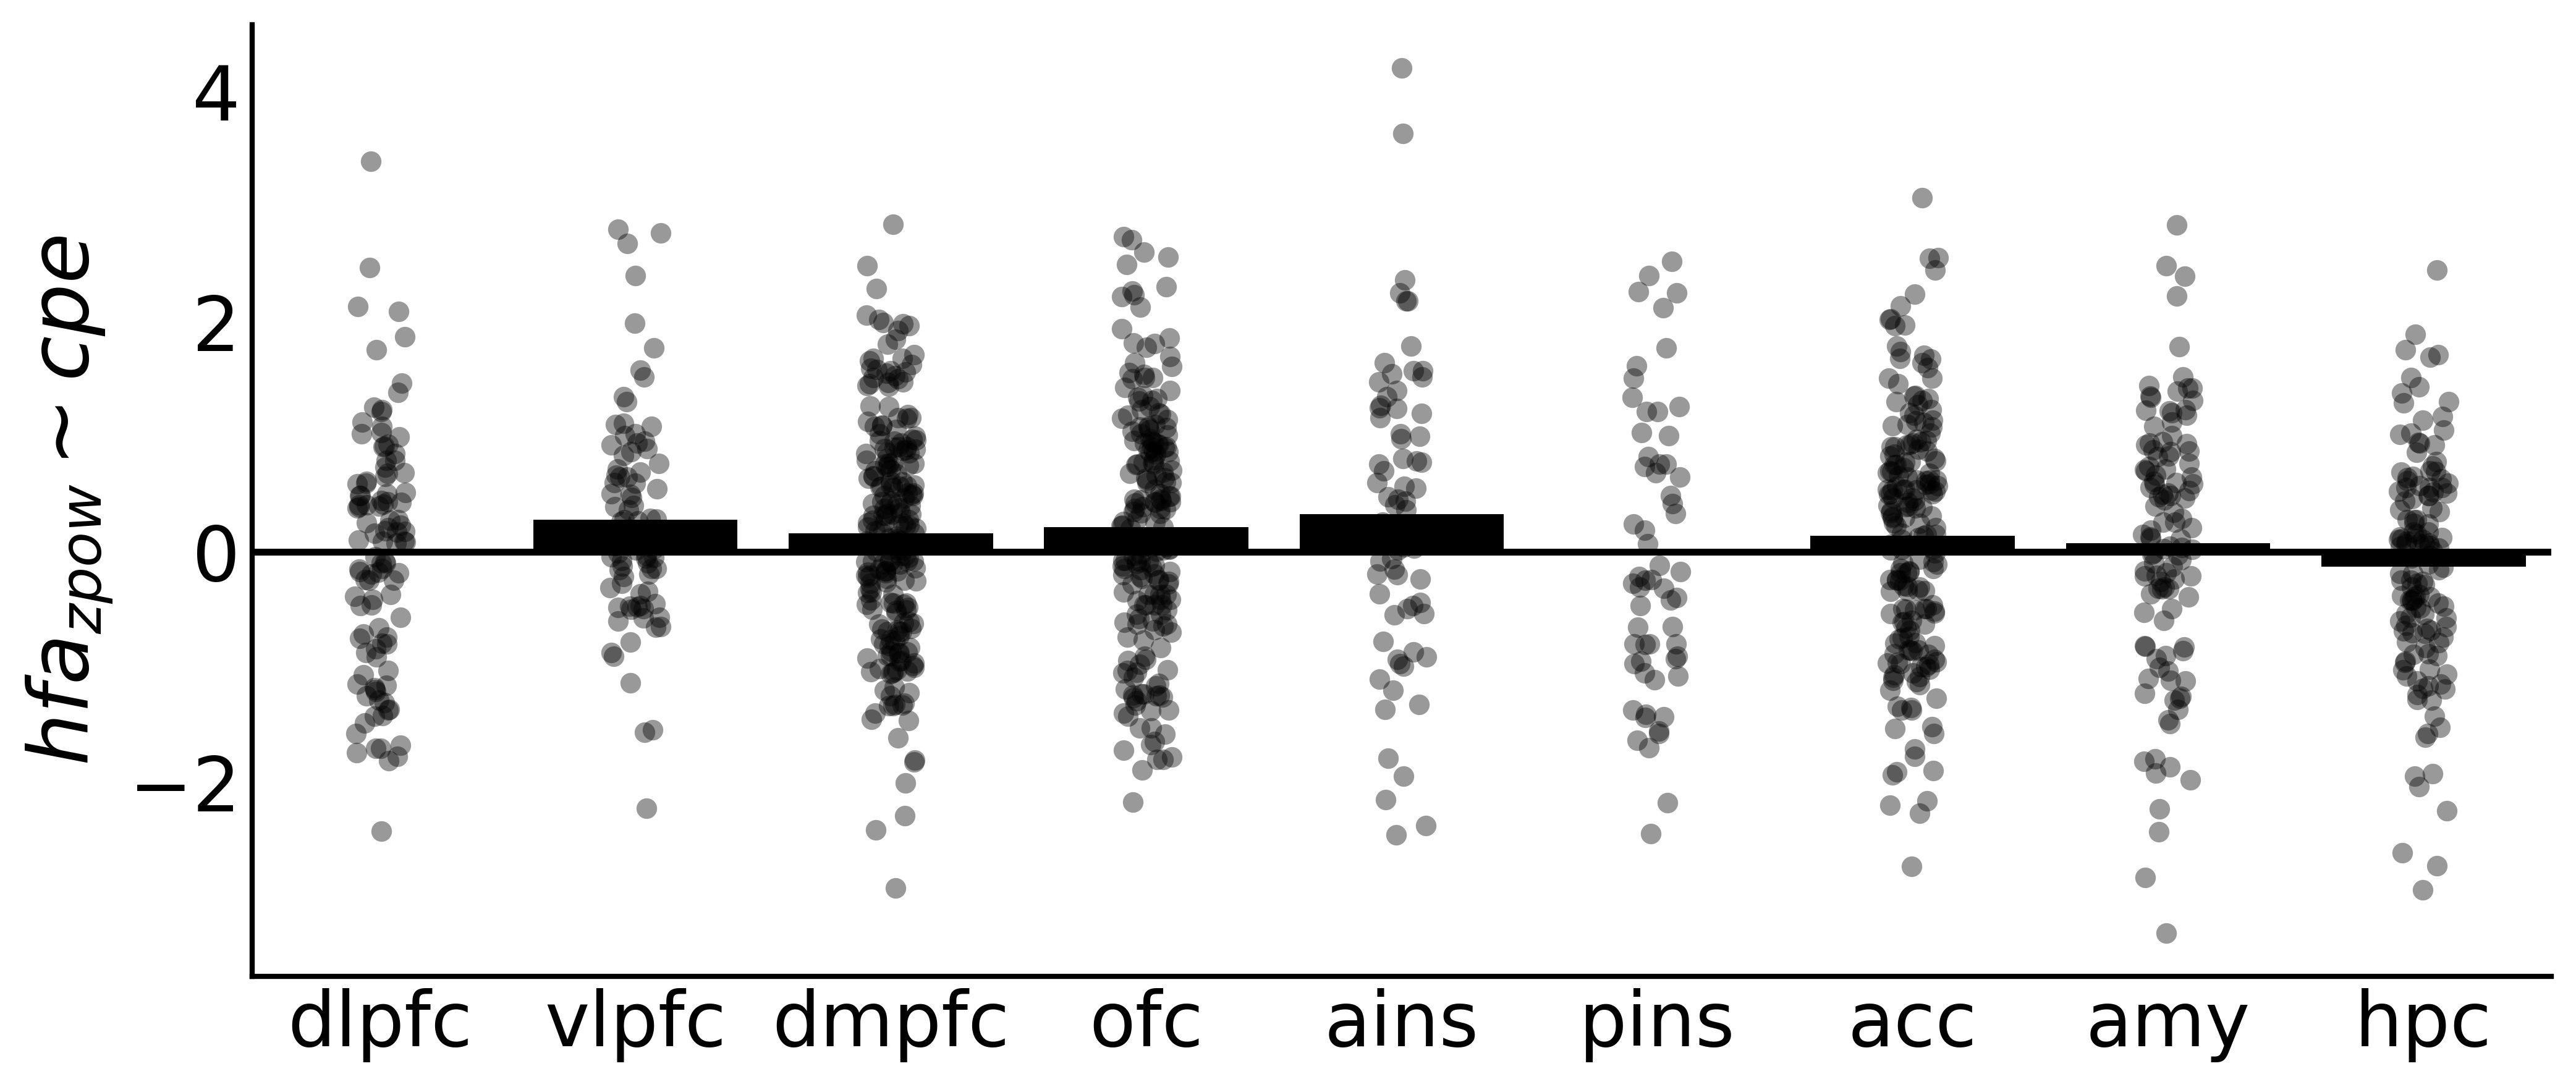

In [27]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim cpe$'


plot_roi_model_results(results,'roi',cpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

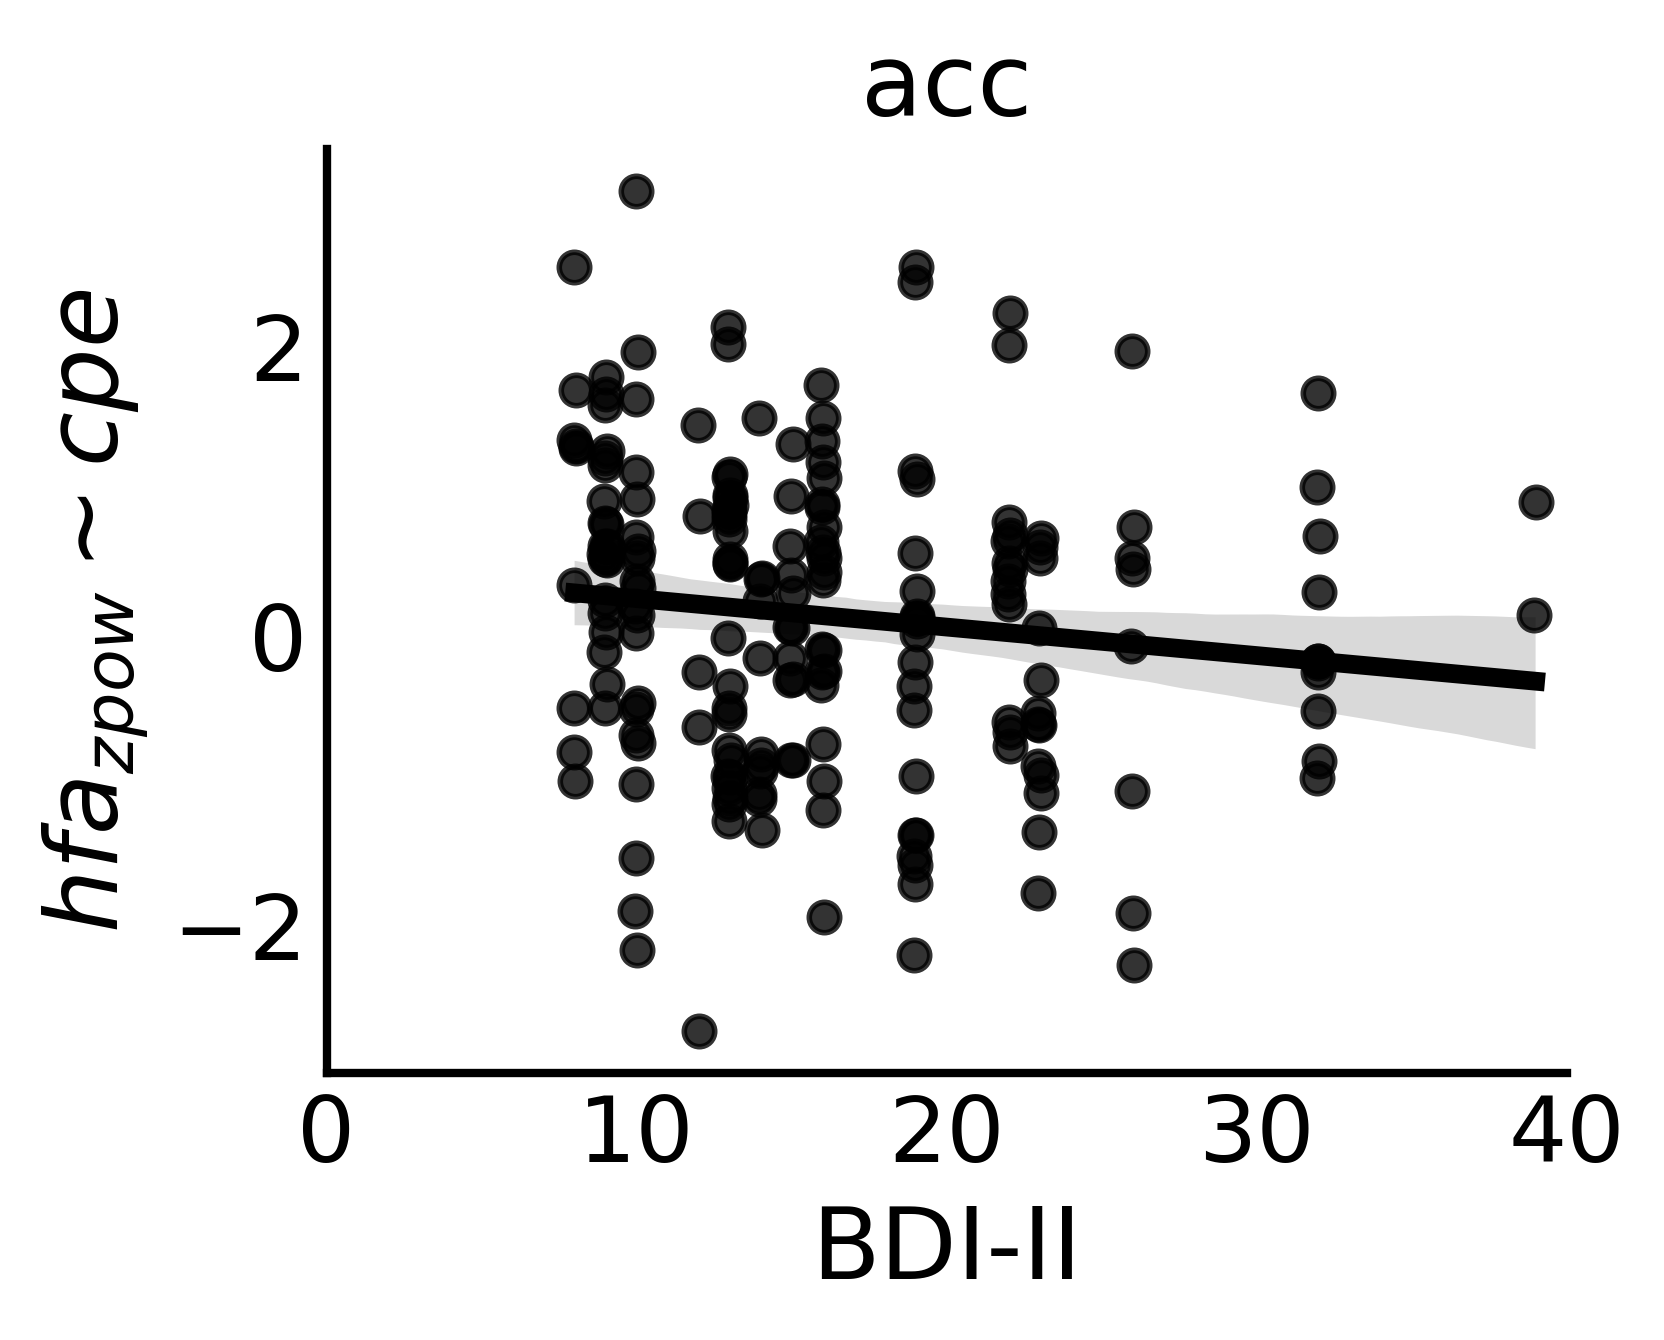

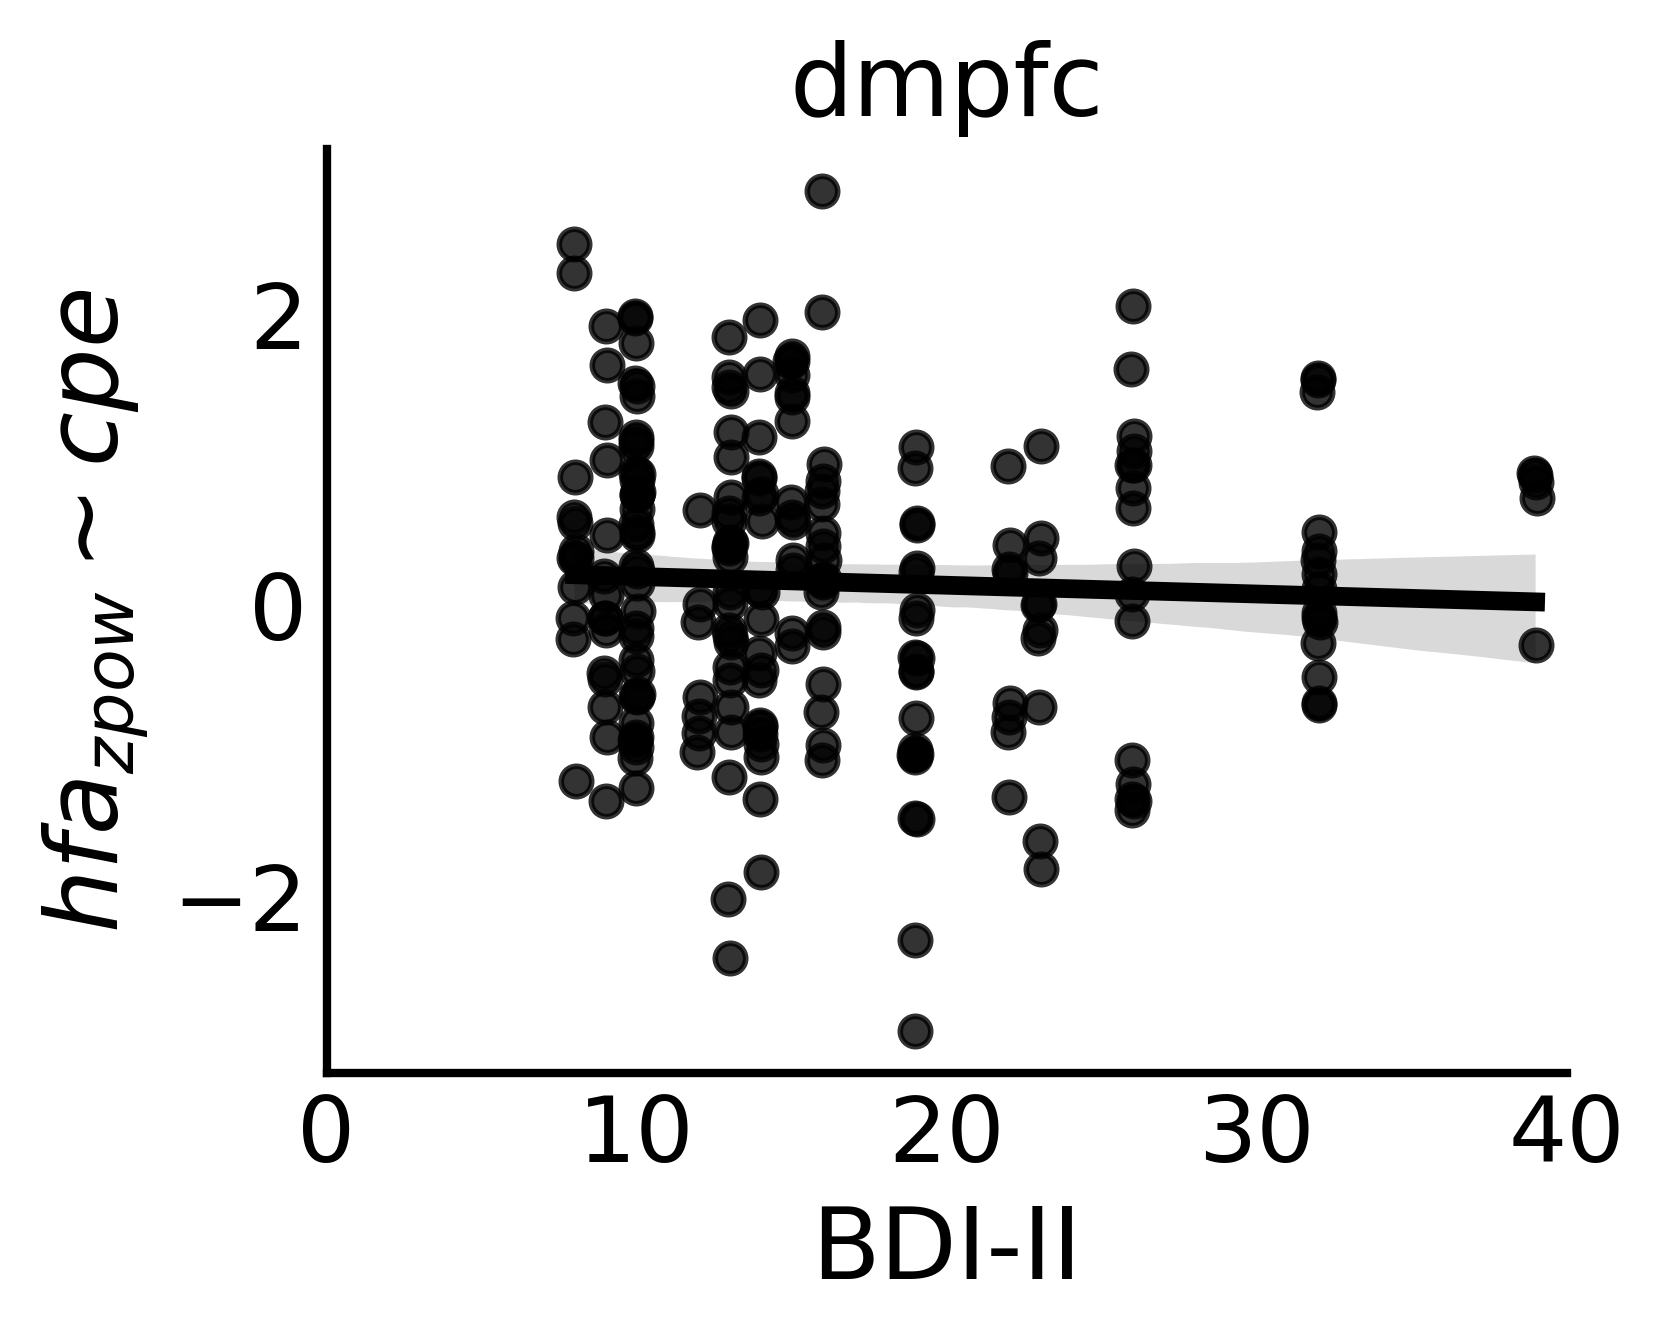

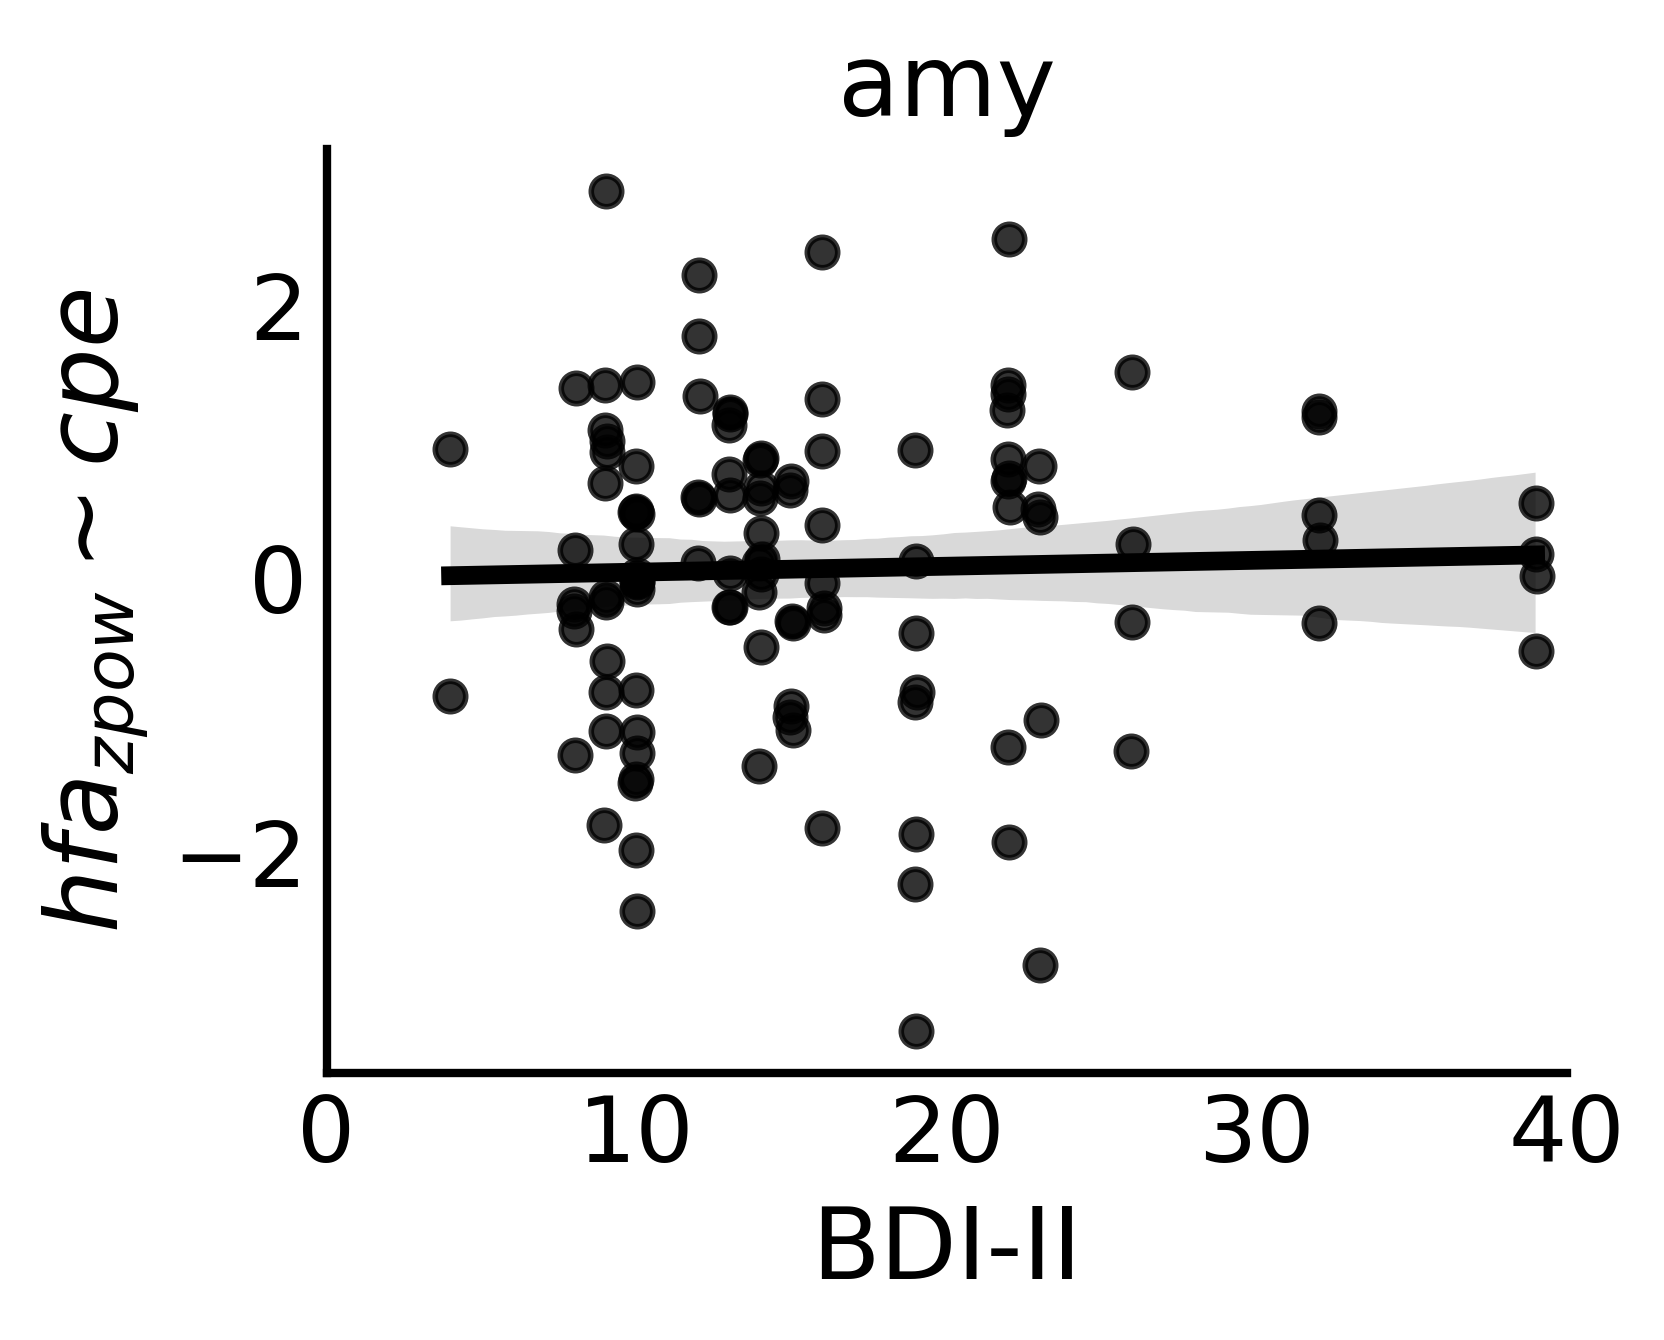

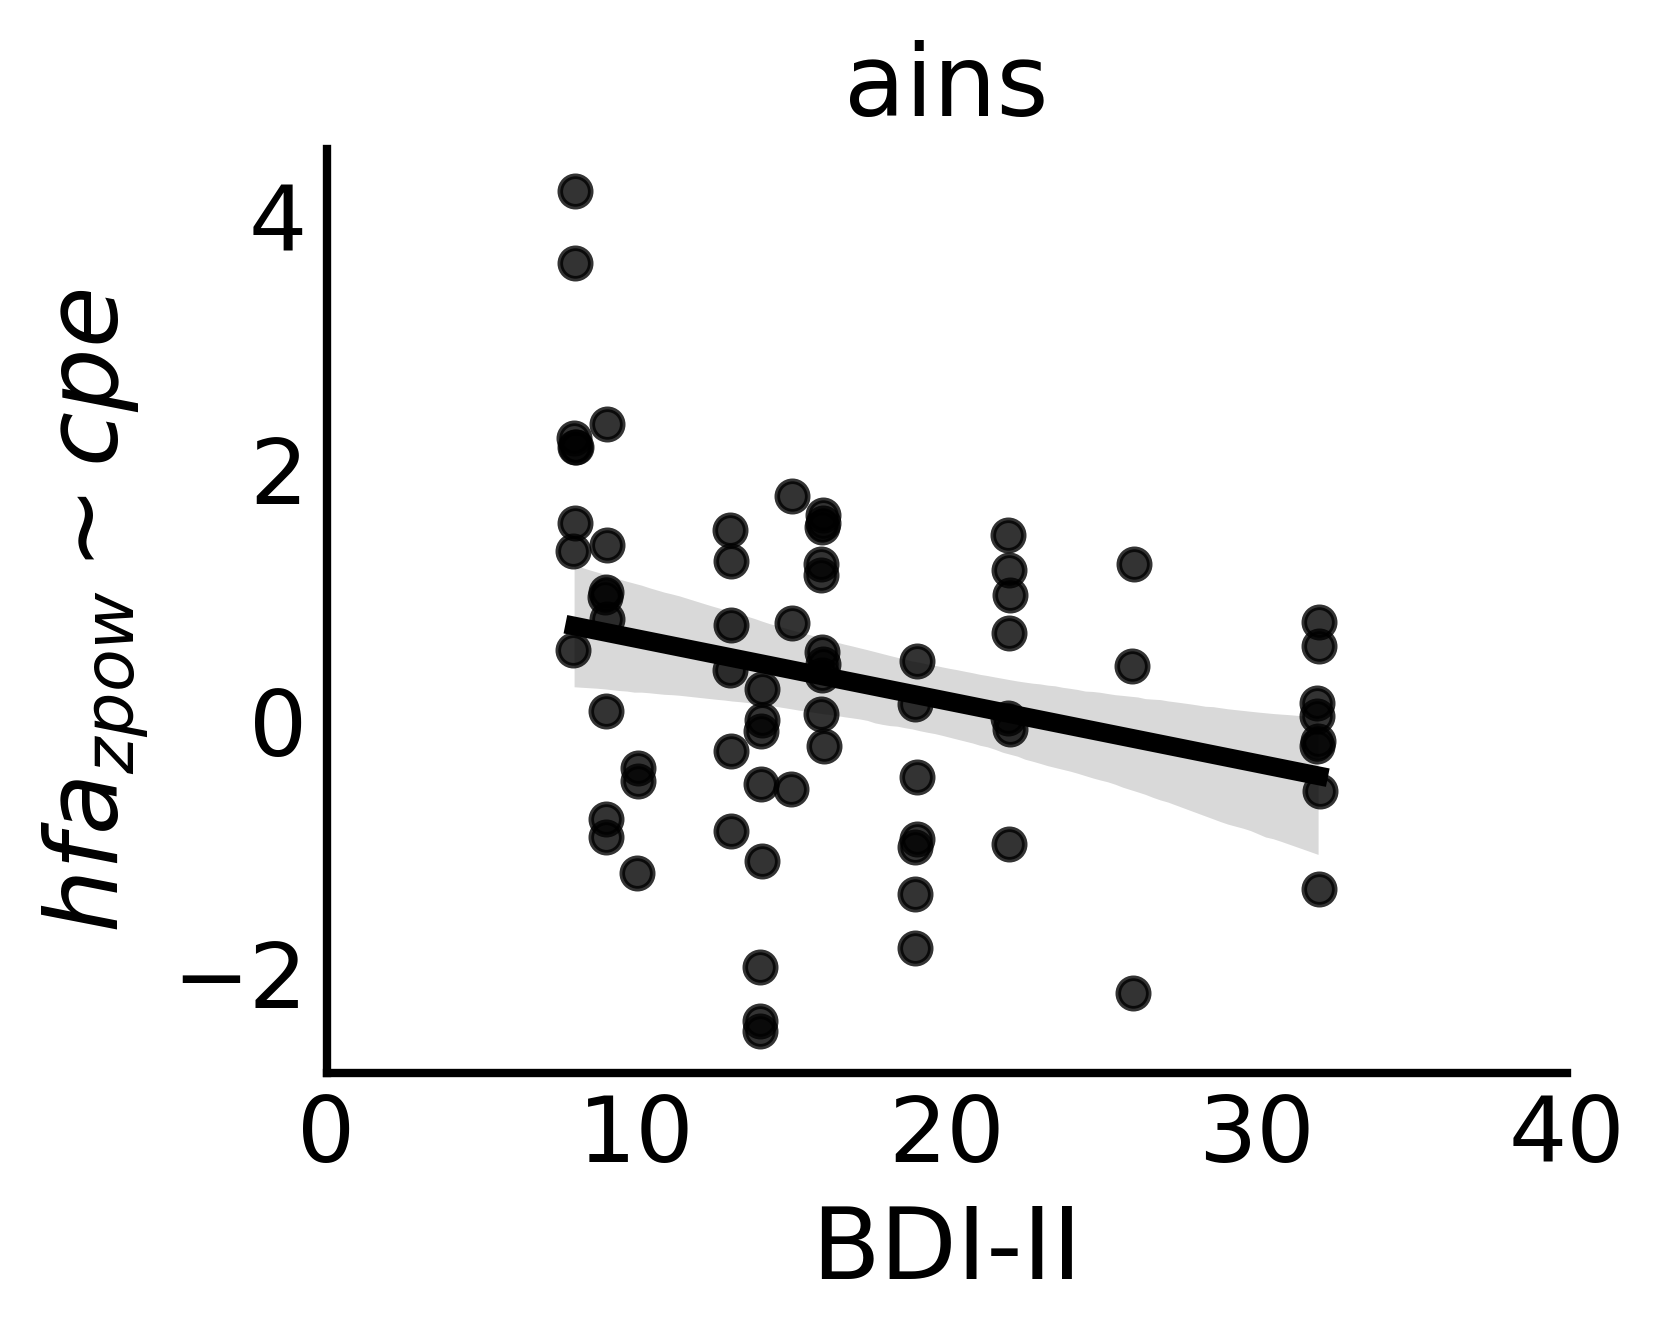

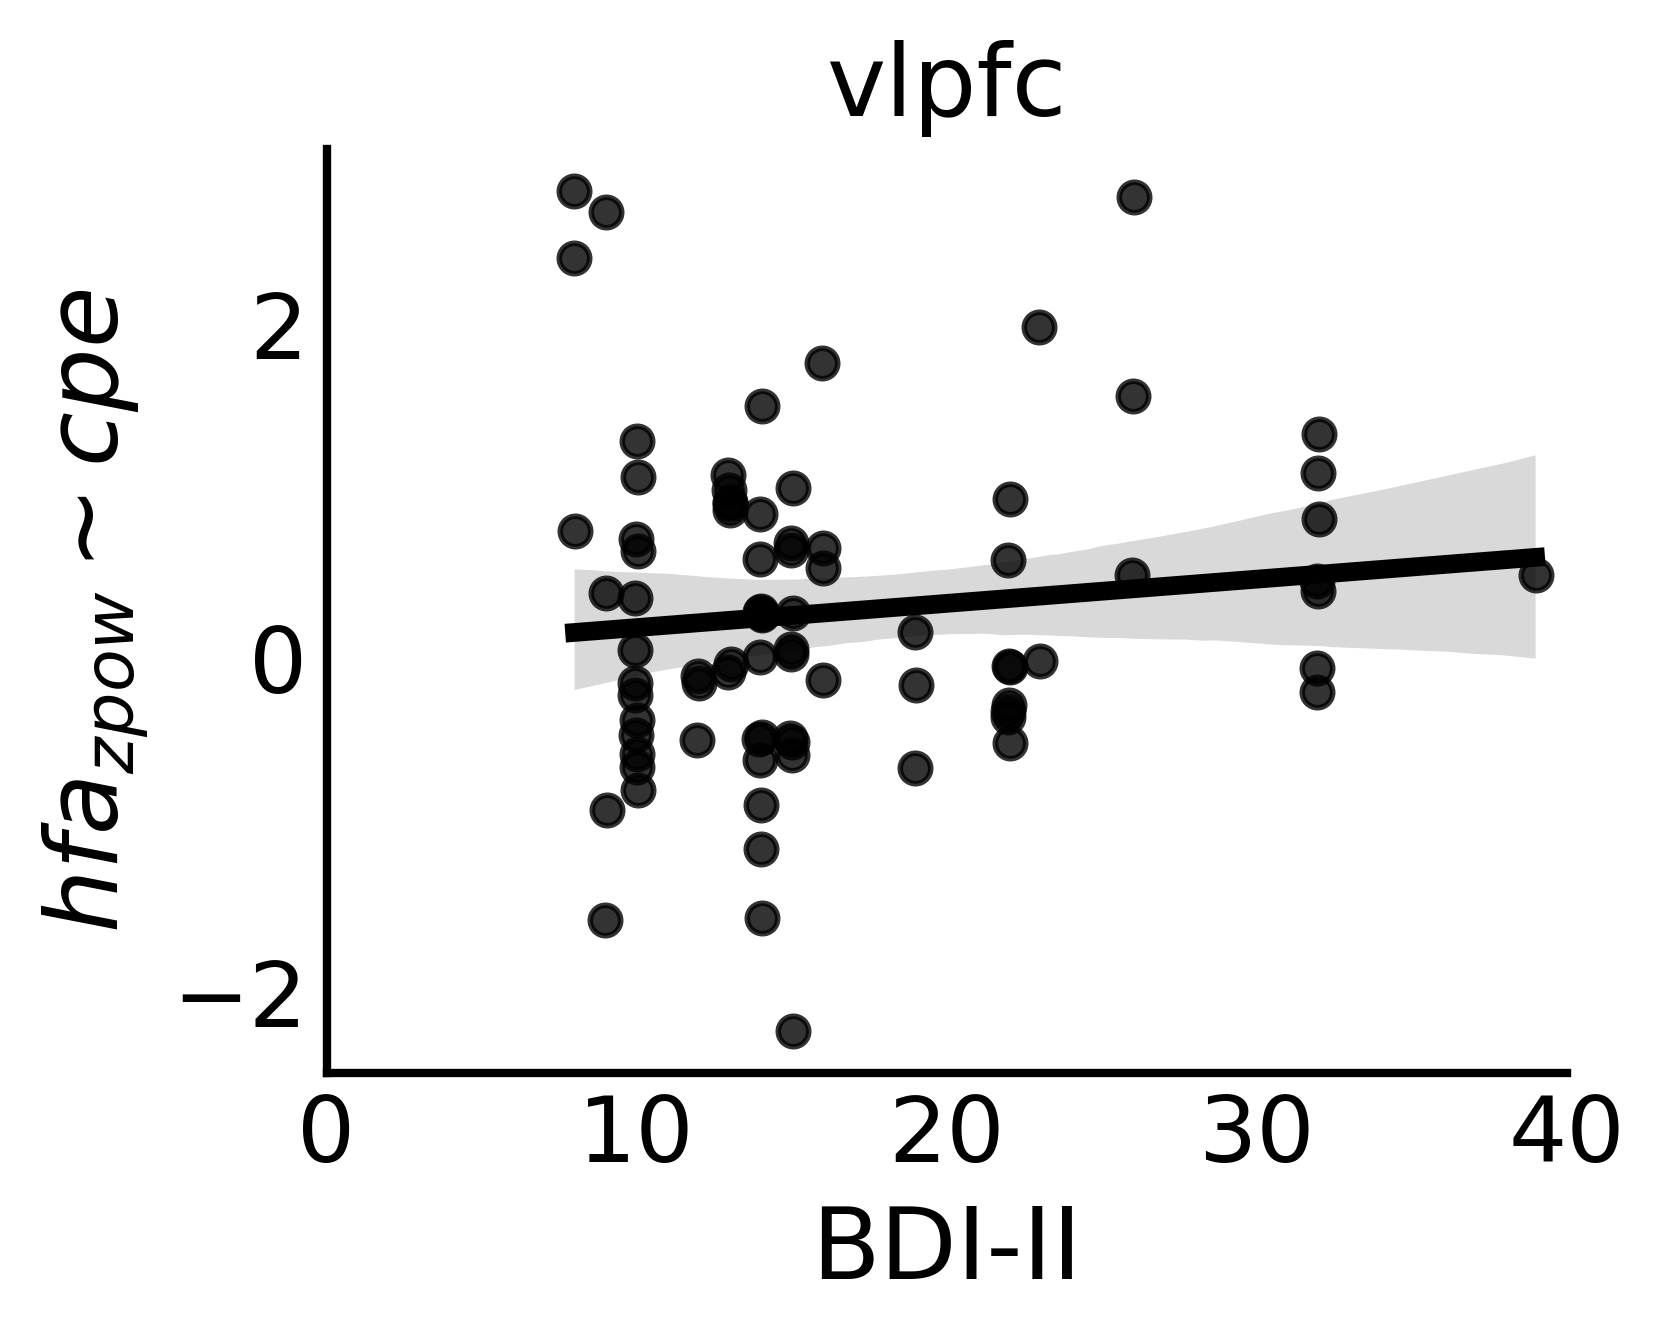

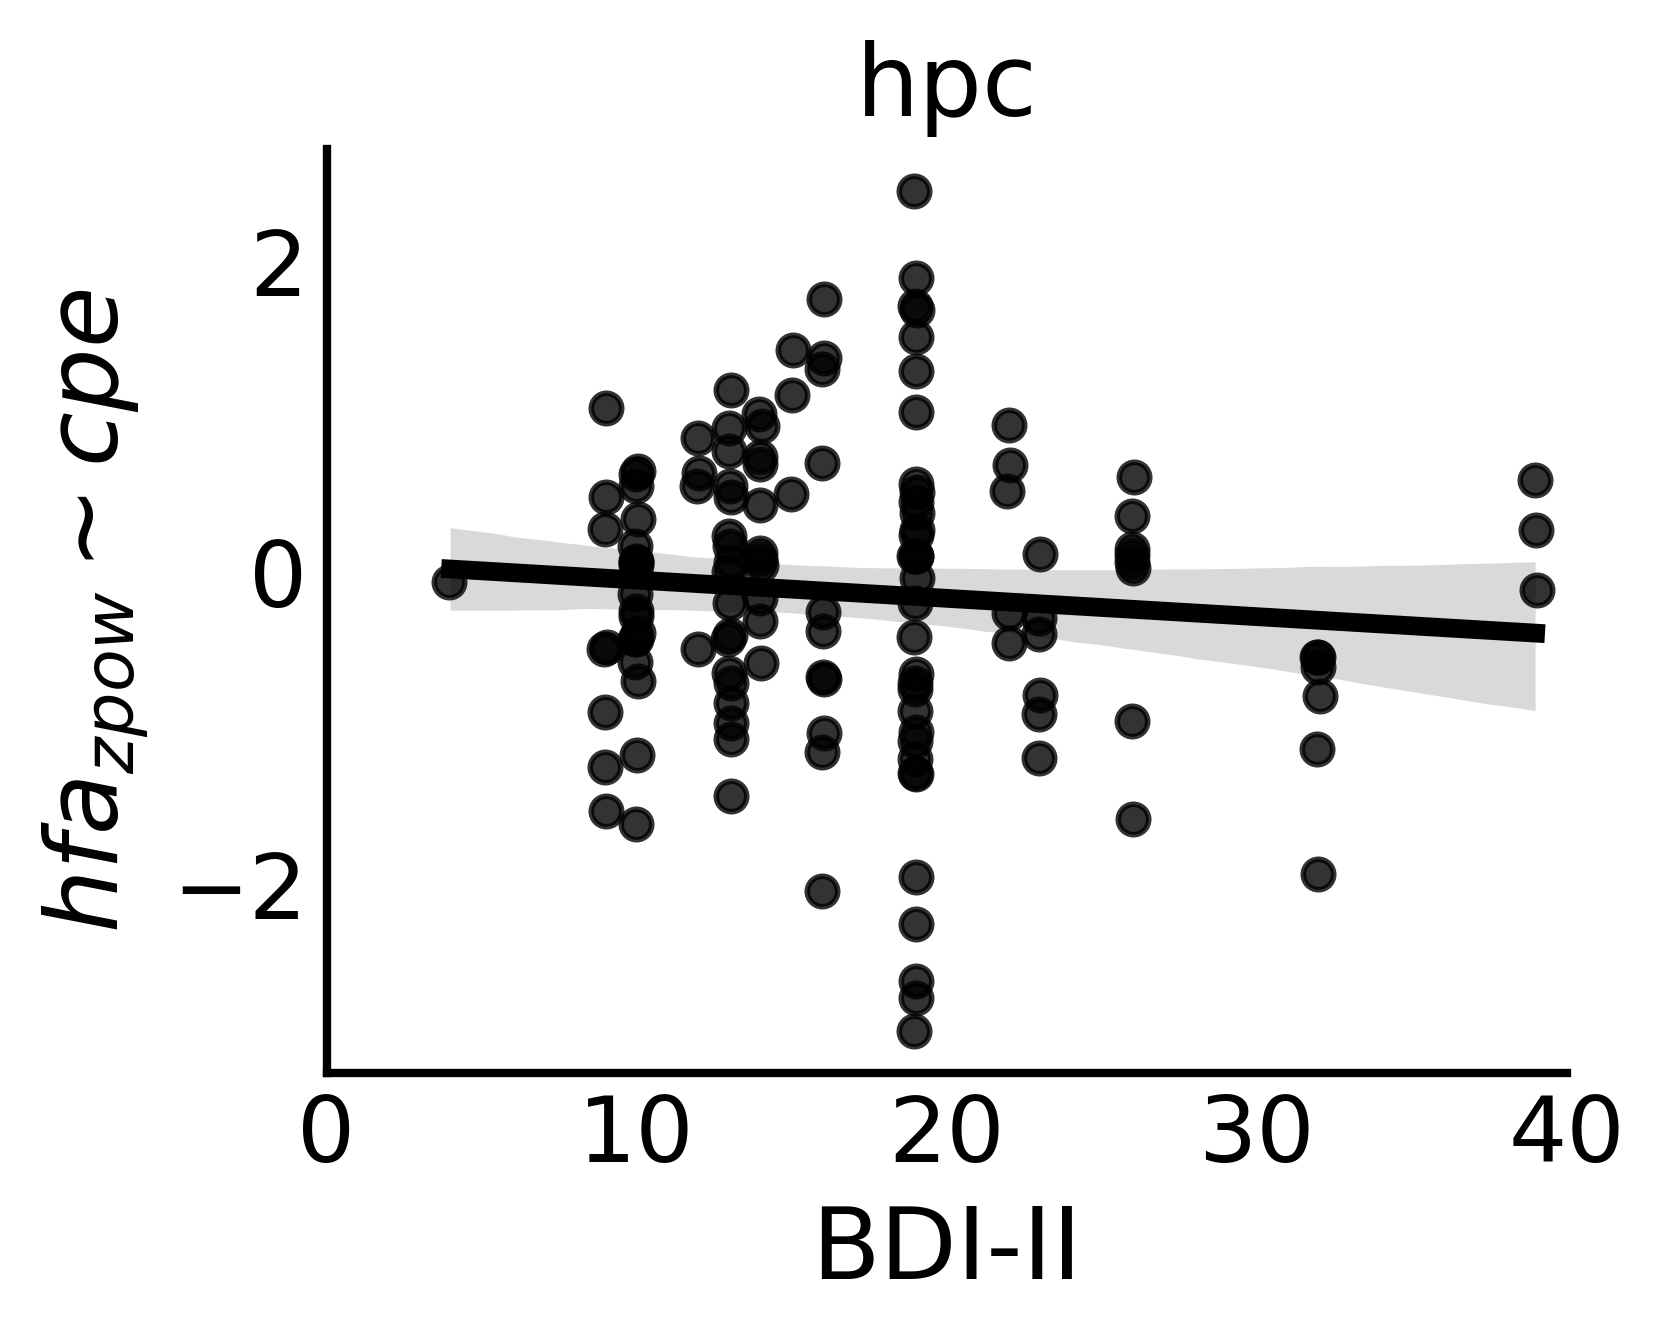

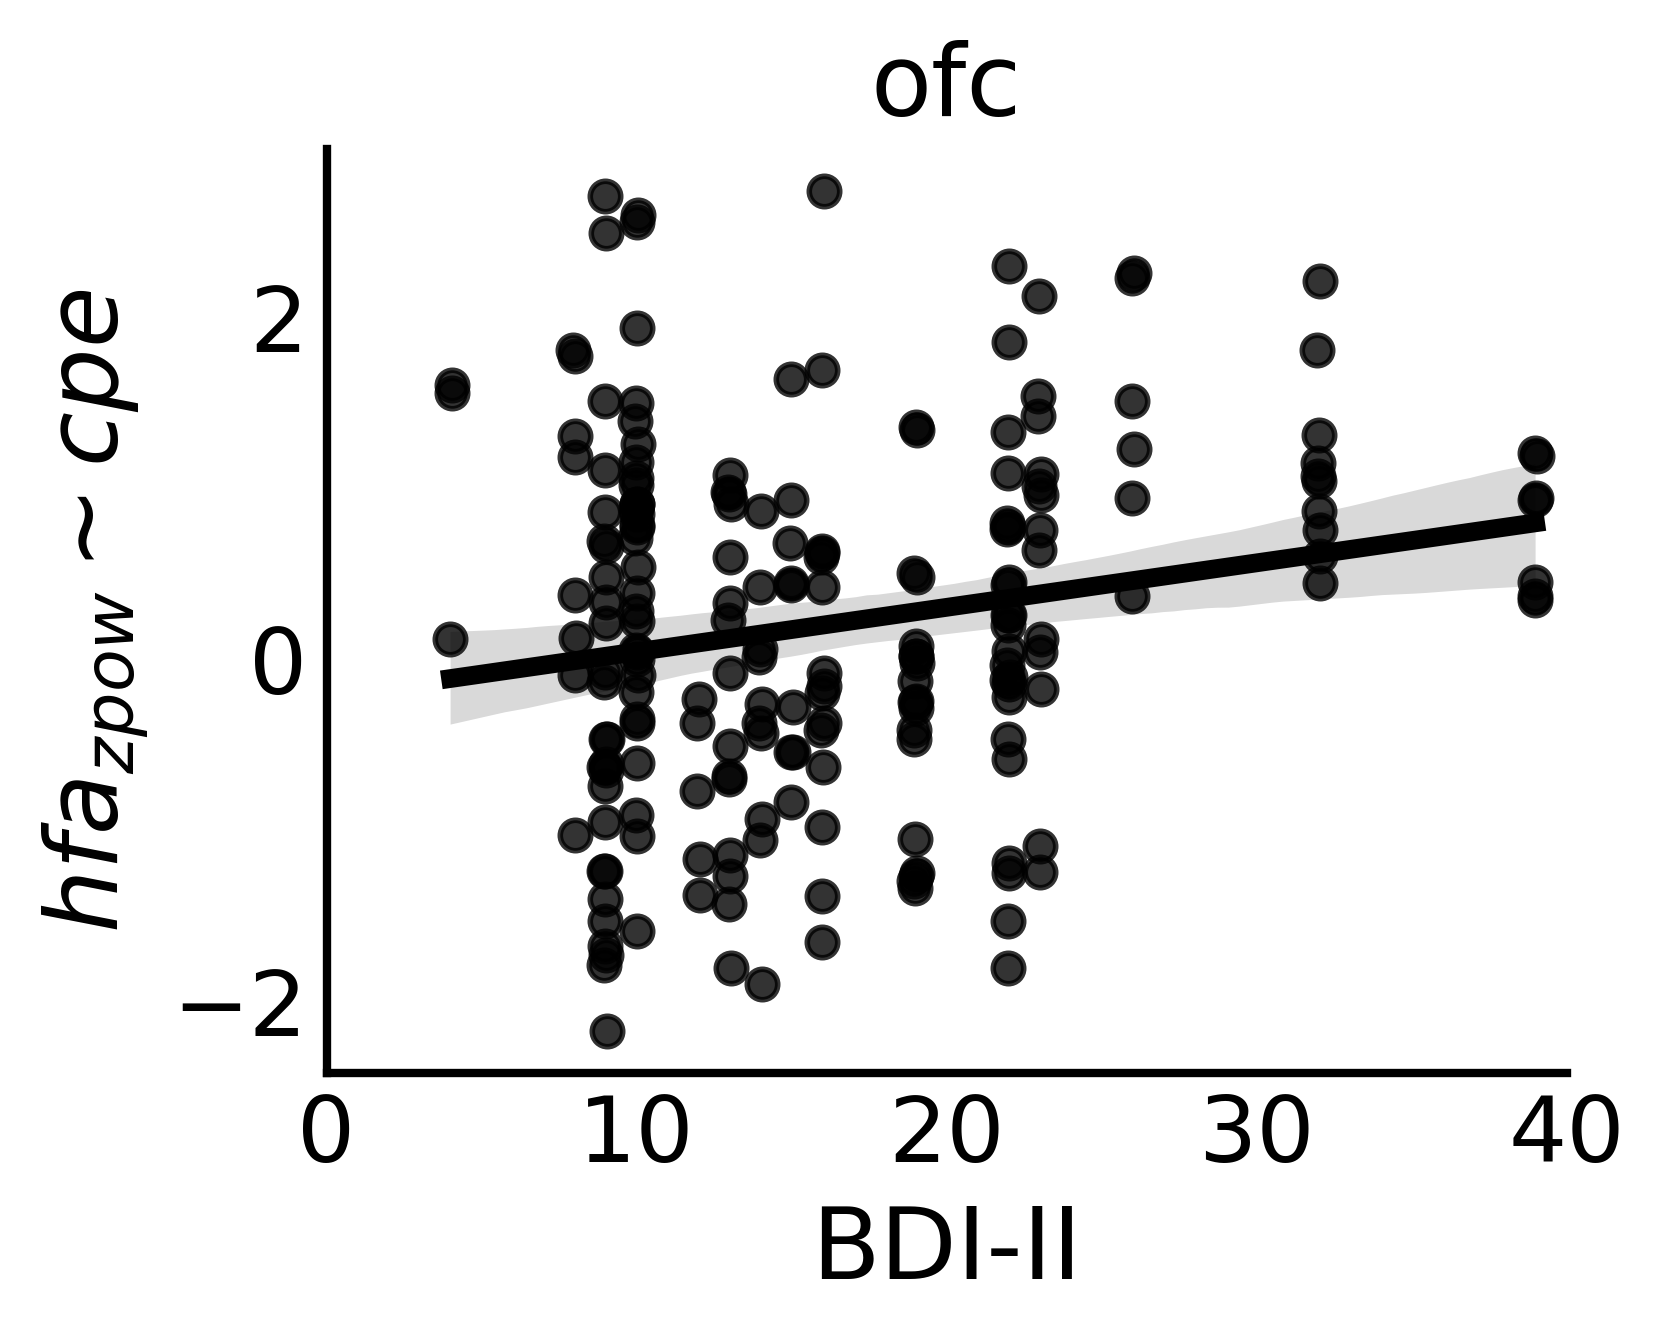

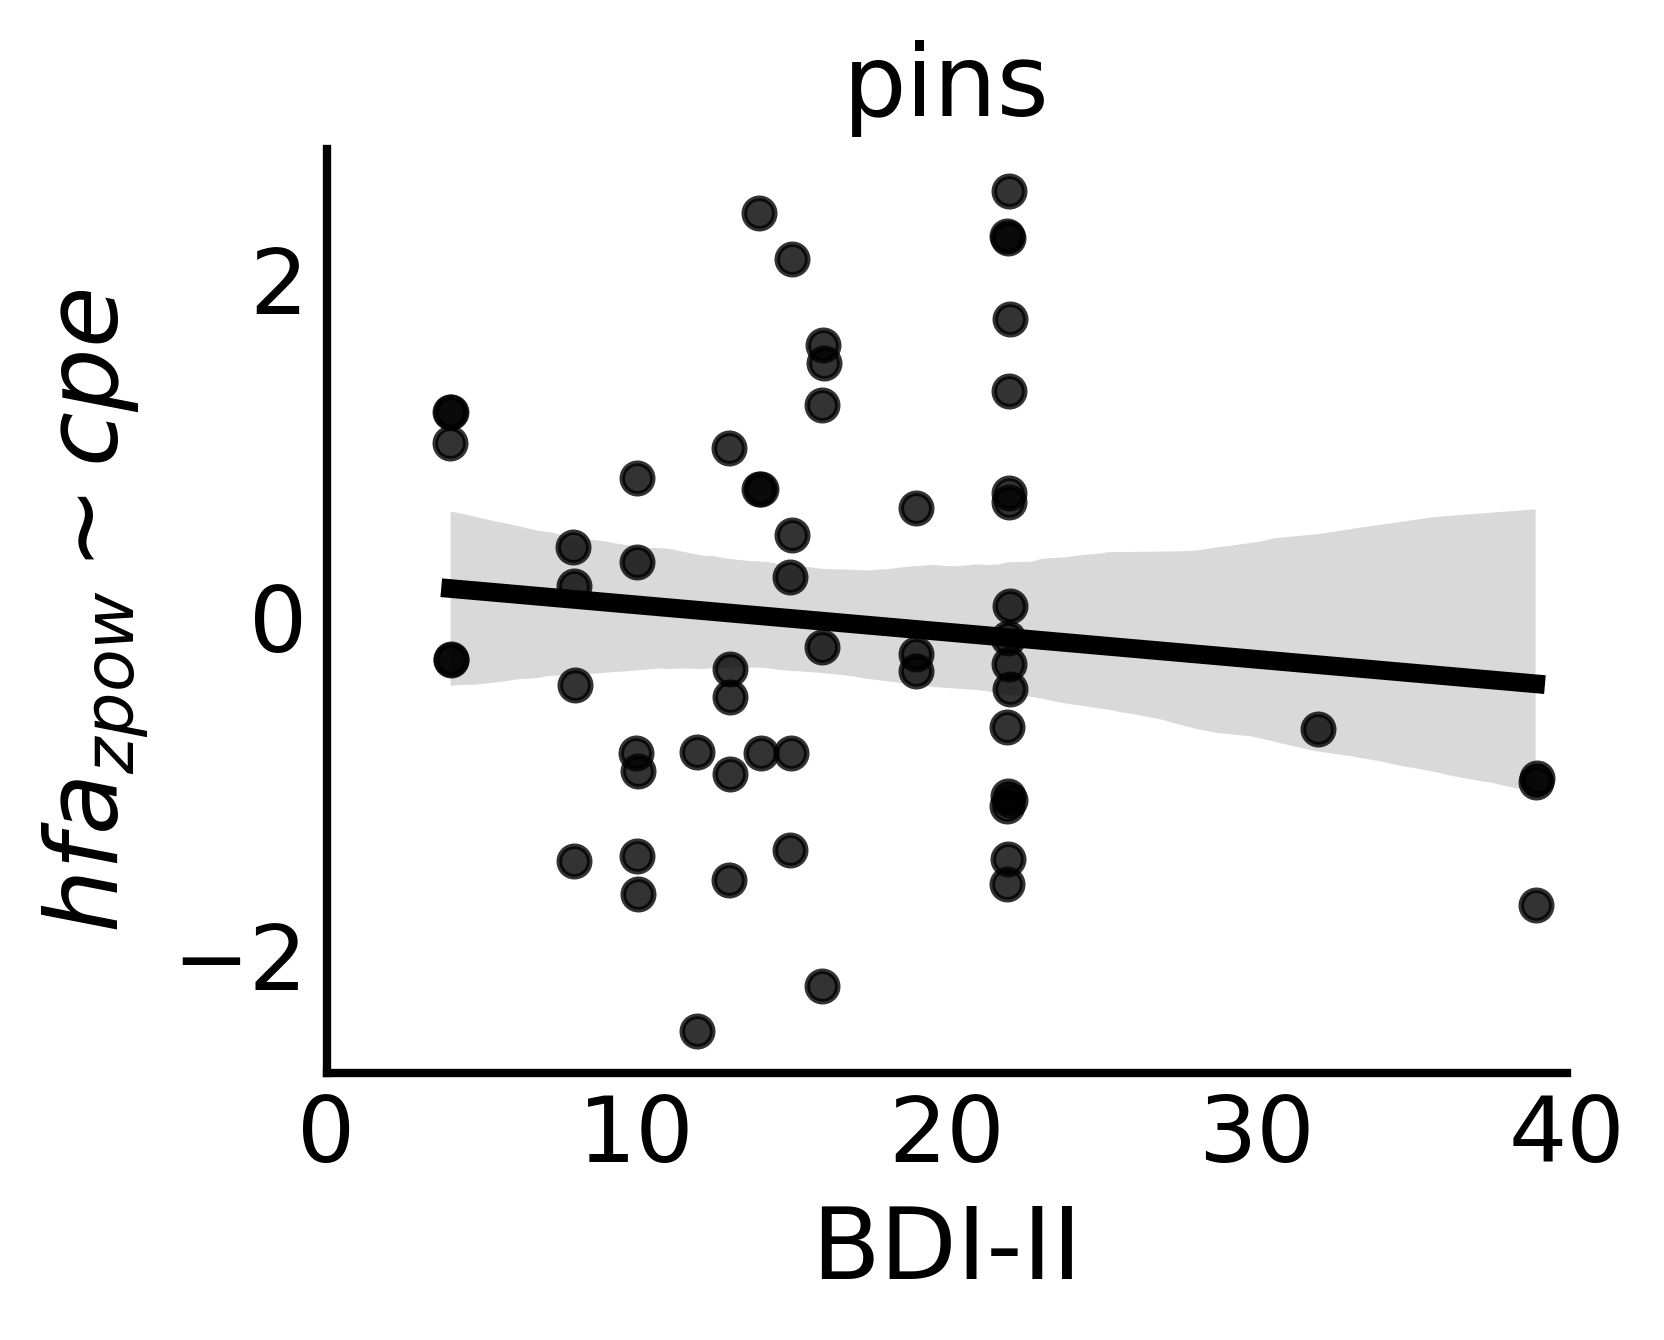

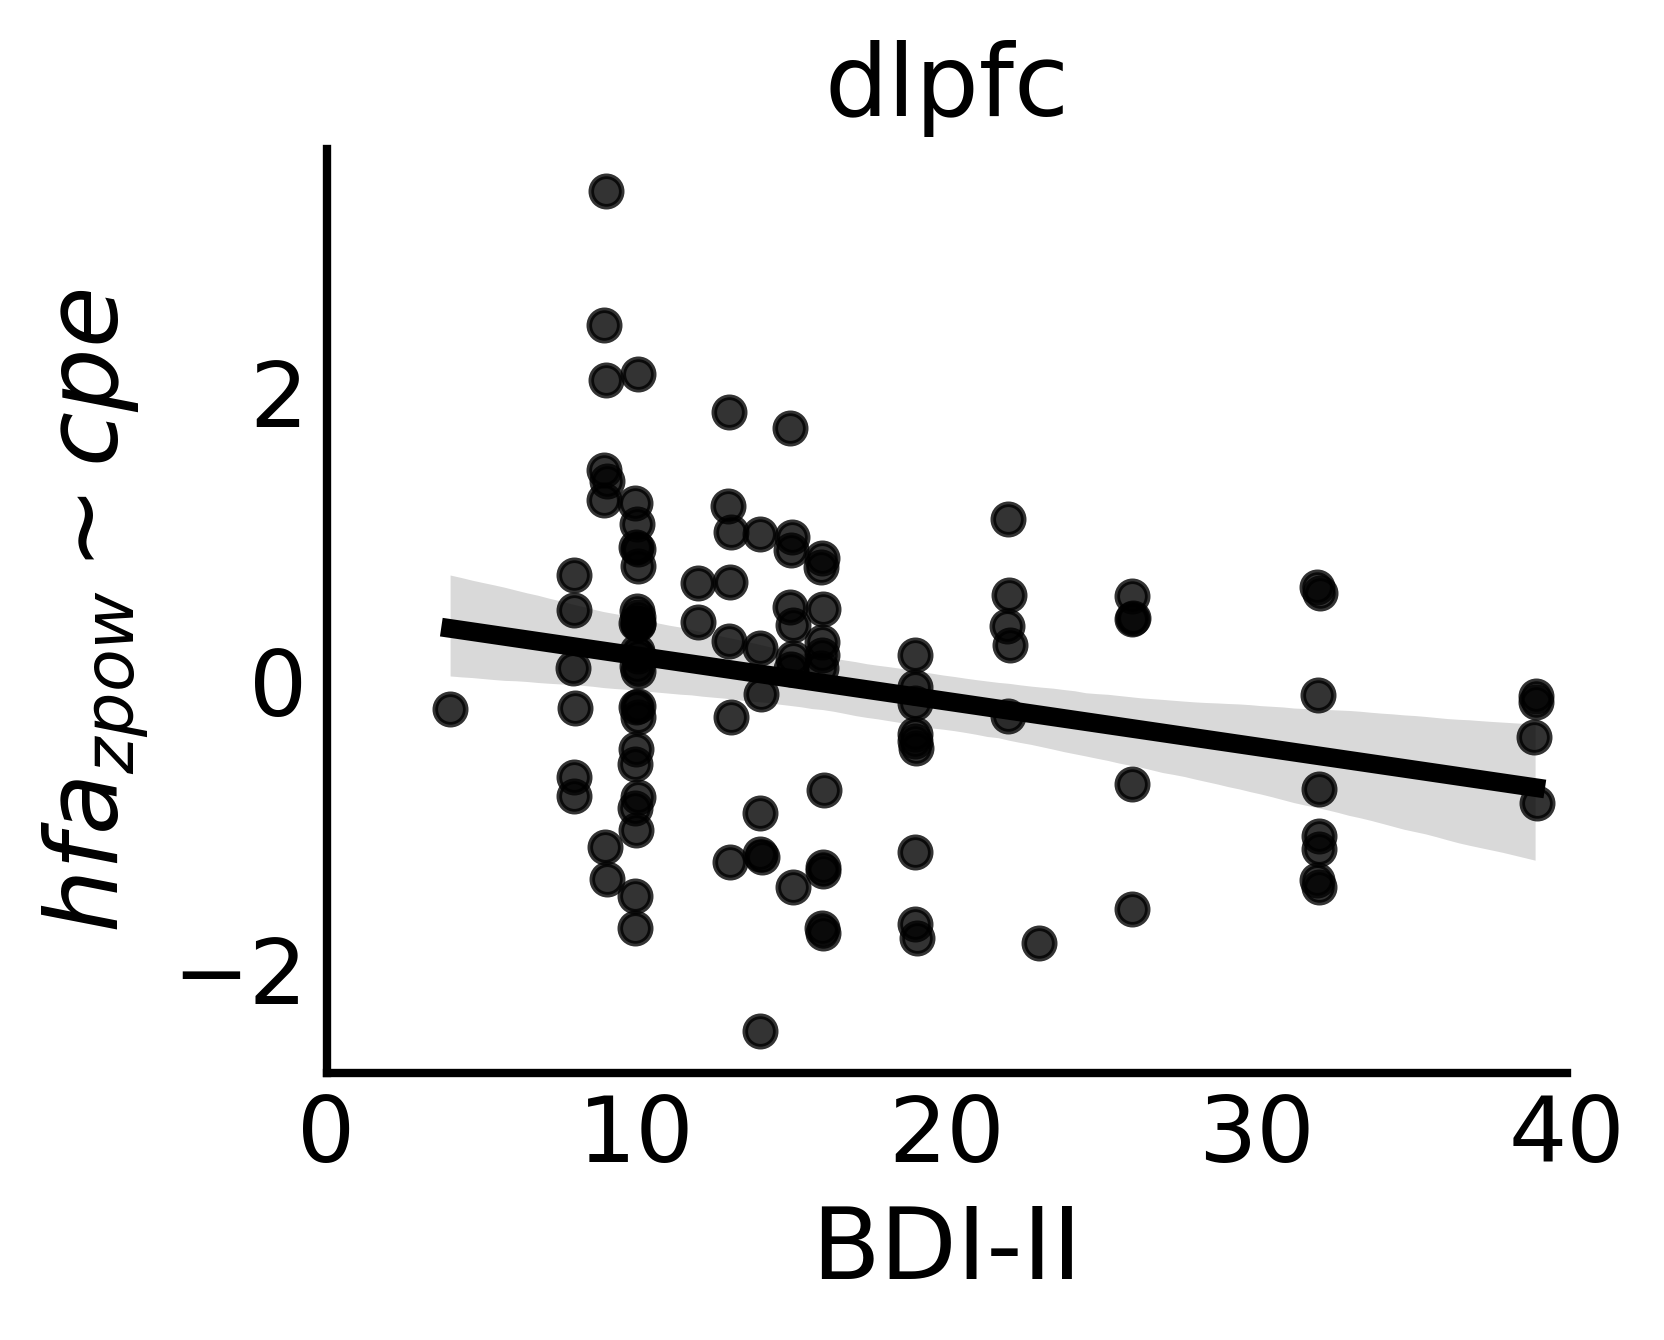

In [28]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_errormodels-bdi_cpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [29]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        21:27:16                                         
No. Iterations:                    16                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9067      0.438     36.289     

# RPE Encoding

In [30]:
sig_data = results[results.P_Value_rpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0      MS002_lacas1-lacas2   MS002    acc   14                     0.032249   
4      MS002_lacas5-lacas6   MS002    acc   14                     0.032351   
5      MS002_lacas6-lacas7   MS002  dmpfc   14                     0.019657   
8     MS002_lacas9-lacas10   MS002  dmpfc   14                    -0.022983   
12     MS002_laims1-laims2   MS002   ains   14                     0.035760   
...                    ...     ...    ...  ...                          ...   
1173       DA039_rof2-rof3   DA039    ofc   22                    -0.015384   
1174       DA039_rof3-rof4   DA039    ofc   22                     0.020983   
1175       DA039_rof4-rof5   DA039    ofc   22                     0.016237   
1176       DA039_rof5-rof6   DA039    ofc   22                    -0.002283   
1177       DA039_rof6-rof7   DA039  dlpfc   22                    -0.033575   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.036820                   0.030620   
4                                  -0.027808                  -0.016443   
5                                  -0.018239                   0.019958   
8                                  -0.017567                  -0.051581   
12                                 -0.028950                  -0.003187   
...                                      ...                        ...   
1173                               -0.006509                   0.037206   
1174                               -0.042046                   0.032246   
1175                               -0.032519                   0.042954   
1176                               -0.012441                   0.049566   
1177                               -0.011078                   0.006276   

      Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  \
0                  0.047835               0.008746                 0.006474   
4                  0.054061              -0.029593                 0.012599   
5                  0.055515              -0.021196                 0.006895   
8                 -0.065247               0.025930                -0.034639   
12                 0.087510              -0.050489                 0.015570   
...                     ...                    ...                      ...   
1173               0.041961               0.005152                -0.016116   
1174               0.068369               0.002686                 0.005646   
1175               0.070068              -0.001094                 0.005209   
1176               0.052020              -0.005058                -0.004705   
1177               0.048204              -0.004523                -0.038016   

      ...  Z_Score_TrialEV  Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
0     ...         1.509777     2.149115     0.400898           0.096035   
4     ...        -0.842877     2.482245    -1.342158           0.187744   
5     ...         1.013018     2.518674    -0.948672           0.384849   
8     ...        -1.867939    -2.127702     0.889770           0.581998   
12    ...        -0.191734     4.153414    -2.380779           0.164089   
...   ...              ...          ...          ...                ...   
1173  ...         2.179271     2.038485     0.201655           0.919940   
1174  ...         1.272115     2.044341     0.046777           0.162538   
1175  ...         1.999753     2.498252    -0.032768           0.254033   
1176  ...         2.555232     2.073268    -0.218269           0.772931   
1177  ...         0.379102     2.258861    -0.245135           0.527543   

      P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_rpe  P_Value_cpe  \
0                         0.094838         0.131100     0.031625     0.688495   
4                         0.185343         0.399297     0.013056     0.179545   
5                         0.377942         0.311052     0.011780     

In [31]:
sig_data.roi.value_counts()



roi
ofc      38
acc      26
dmpfc    25
dlpfc    16
amy      11
ains     10
pins      9
vlpfc     8
hpc       5
Name: count, dtype: int64

In [32]:
sig_data.roi.unique()



array(['acc', 'dmpfc', 'ains', 'ofc', 'vlpfc', 'pins', 'dlpfc', 'amy',
       'hpc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [33]:
# add mask col for sig cpe elecs 
results['rpe_sig']   = results['P_Value_rpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.032249   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.031856   
2  MS002_lacas3-lacas4   MS002  acc   14                    -0.006776   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.012777   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.032351   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.036820                   0.030620   
1                               -0.048324                  -0.004094   
2                               -0.002345                  -0.018509   
3                               -0.017243                  -0.019432   
4                               -0.027808                  -0.016443   

   Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  ...  \
0               0.047835               0.008746                 0.006474  ...   
1               0.029514               0.005562                -0.000976  ...   
2               0.004390              -0.017195                -0.008534  ...   
3              -0.001837              -0.026059                 0.000384  ...   
4               0.054061              -0.029593                 0.012599  ...   

   Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  P_Value_GambleChoice[T.safe]  \
0     2.149115     0.400898           0.096035                      0.094838   
1     1.369833     0.246013           0.032577                      0.032563   
2     0.207210    -0.887833           0.891118                      0.890215   
3    -0.095476    -1.127010           0.407368                      0.404942   
4     2.482245    -1.342158           0.187744                      0.185343   

   P_Value_TrialEV  P_Value_rpe  P_Value_cpe  cpe_sig  bdi_split  rpe_sig  
0         0.131100     0.031625     0.688495        0          0        1  
1         0.824777     0.170739     0.805672        0          0        0  
2         0.245953     0.835846     0.374630        0          0        0  
3         0.309636     0.923937     0.259738        0          0        0  
4         0.399297     0.013056     0.179545        0          0        1  

[5 rows x 32 columns]

In [34]:
rpe_var = 'Z_Score_rpe'

In [35]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [36]:
results.groupby('roi').agg('mean',numeric_only=True)[rpe_var][bar_order]



roi
dlpfc    0.292785
vlpfc   -0.198060
dmpfc   -0.115191
ofc      0.532784
ains     0.172586
pins     0.092204
acc      0.486938
amy      0.187500
hpc      0.209065
Name: Z_Score_rpe, dtype: float64

In [37]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[rpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.rpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].rpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [38]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     26  0.134715              6    5.517814  1.100894e-07   
1  dmpfc      225     25  0.111111              3   -1.409130  1.601835e-01   
2    amy      113     11  0.097345              2    1.654241  1.008786e-01   
3   ains       71     10  0.140845              1    1.033958  3.047147e-01   
4  vlpfc       82      8  0.097561              1   -1.623725  1.083200e-01   
5    hpc      135      5  0.037037              0    2.339184  2.080437e-02   
6    ofc      202     38  0.188119             11    5.687575  4.499492e-08   
7   pins       60      9  0.150000              0    0.519287  6.055031e-01   
8  dlpfc      107     16  0.149533              7    2.268907  2.529939e-02   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.096139            1.0    0.134715      0.0000  
1      0.078437            1.0    0.111111      0.0002  
2      0.055555            1.0    0.097345      0.0263  
3      0.078451            1.0    0.140845      0.0027  
4      0.049476            1.0    0.097561      0.0526  
5      0.014705            1.0    0.037037      0.8101  
6      0.144079            1.0    0.188119      0.0000  
7      0.080545            1.0    0.150000      0.0028  
8      0.096100            1.0    0.149533      0.0001

In [39]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     26  0.134715              6    5.517814  1.100894e-07   
1  dmpfc      225     25  0.111111              3   -1.409130  1.601835e-01   
2    amy      113     11  0.097345              2    1.654241  1.008786e-01   
3   ains       71     10  0.140845              1    1.033958  3.047147e-01   
6    ofc      202     38  0.188119             11    5.687575  4.499492e-08   
7   pins       60      9  0.150000              0    0.519287  6.055031e-01   
8  dlpfc      107     16  0.149533              7    2.268907  2.529939e-02   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.096139            1.0    0.134715      0.0000  
1      0.078437            1.0    0.111111      0.0002  
2      0.055555            1.0    0.097345      0.0263  
3      0.078451            1.0    0.140845      0.0027  
6      0.144079            1.0    0.188119      0.0000  
7      0.080545            1.0    0.150000      0.0028  
8      0.096100            1.0    0.149533      0.0001

# Plot Results

In [40]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_errormodels-rpe_coeff_barplot_{epoch_len}.pdf'


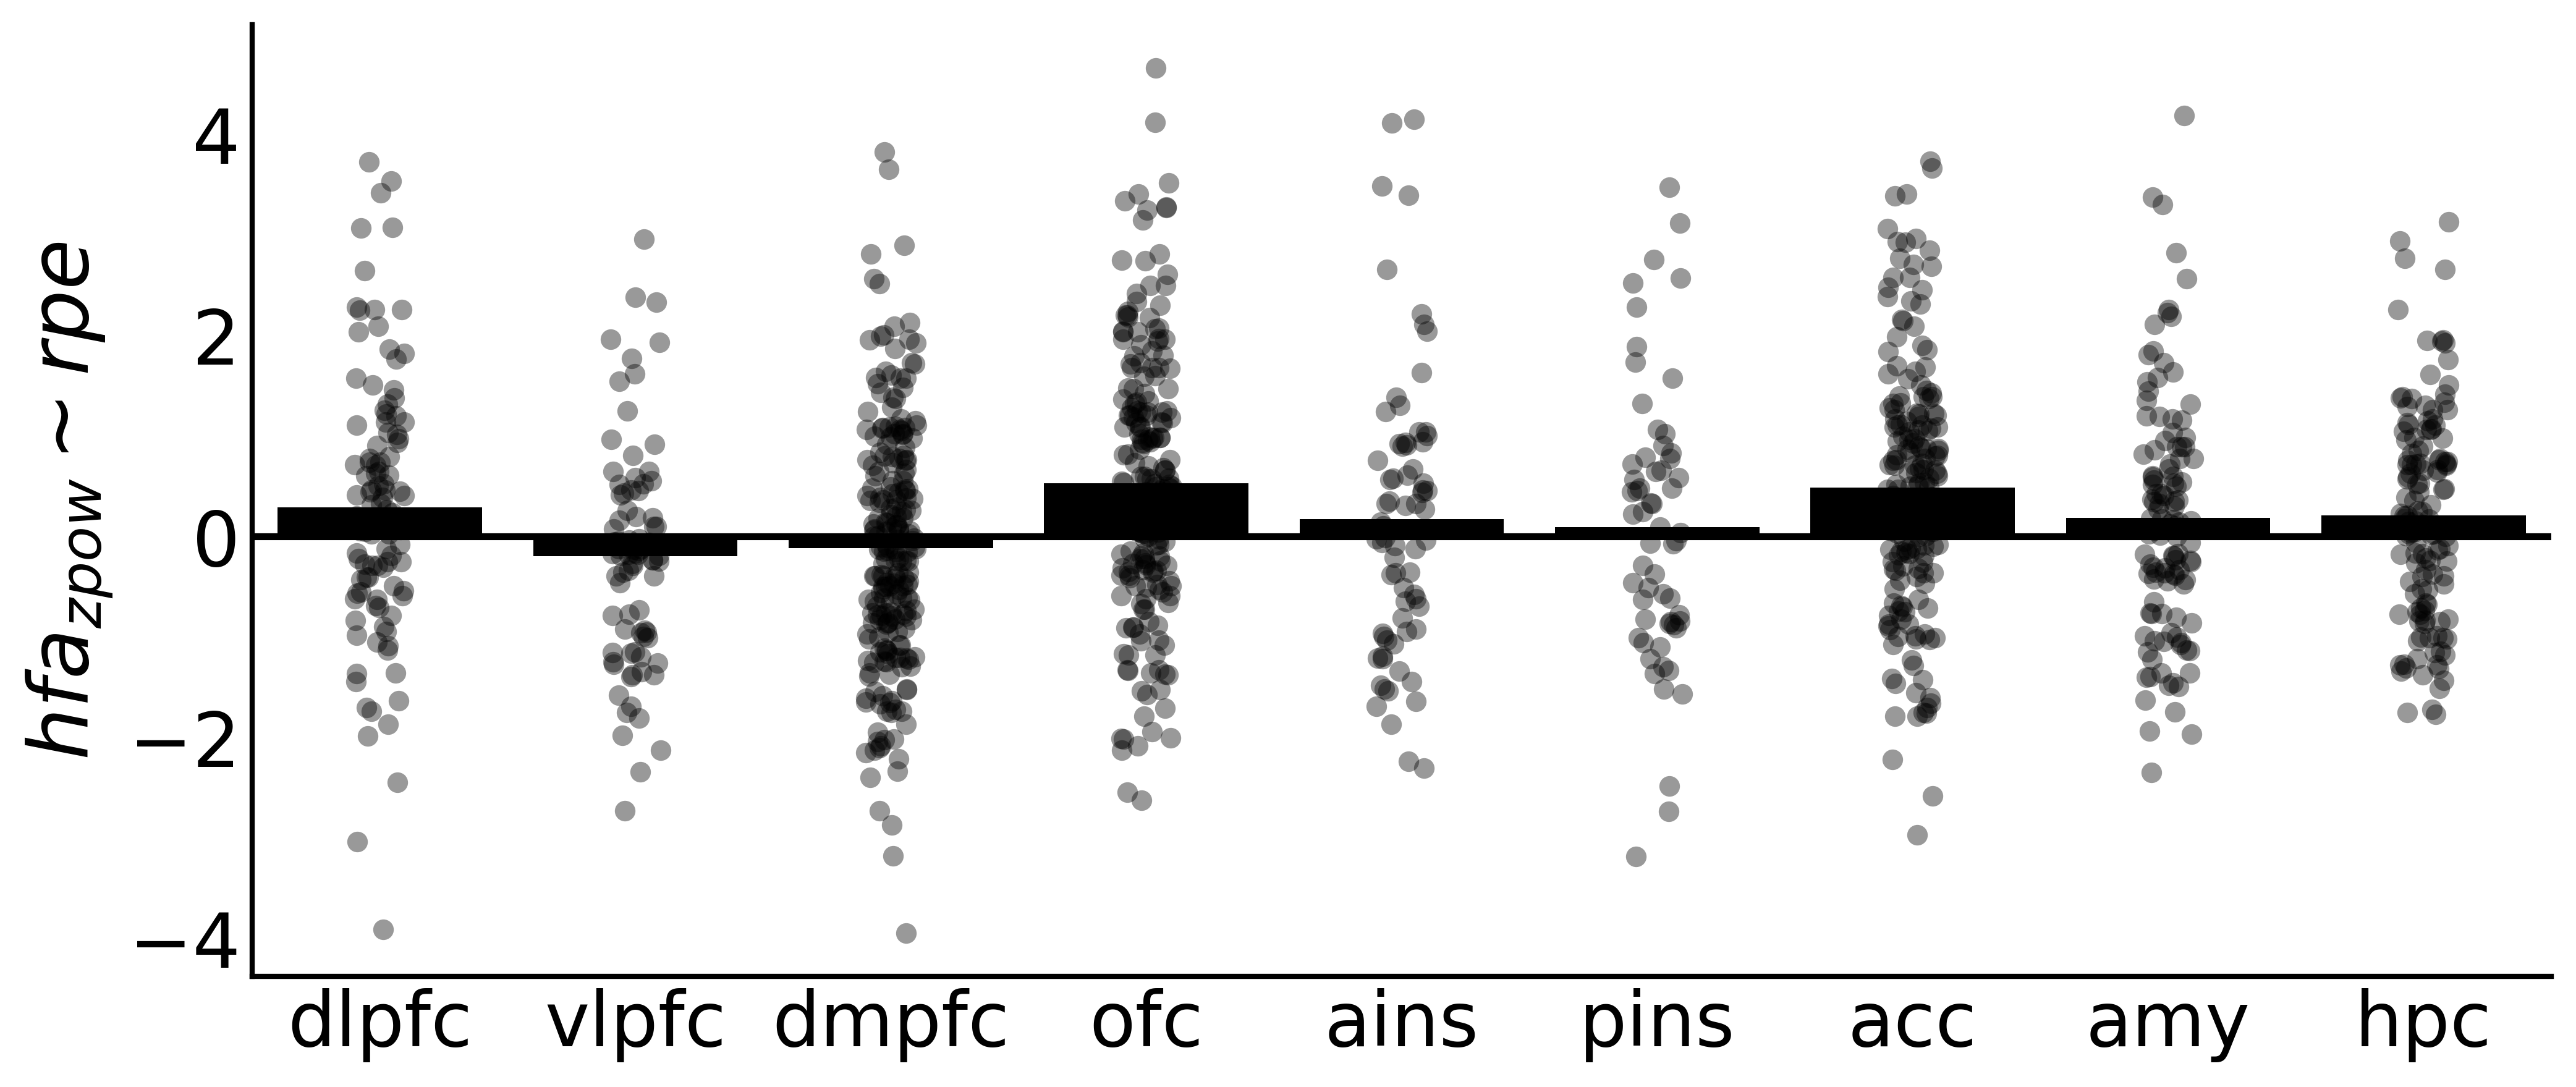

In [41]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim rpe$'


plot_roi_model_results(results,'roi',rpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

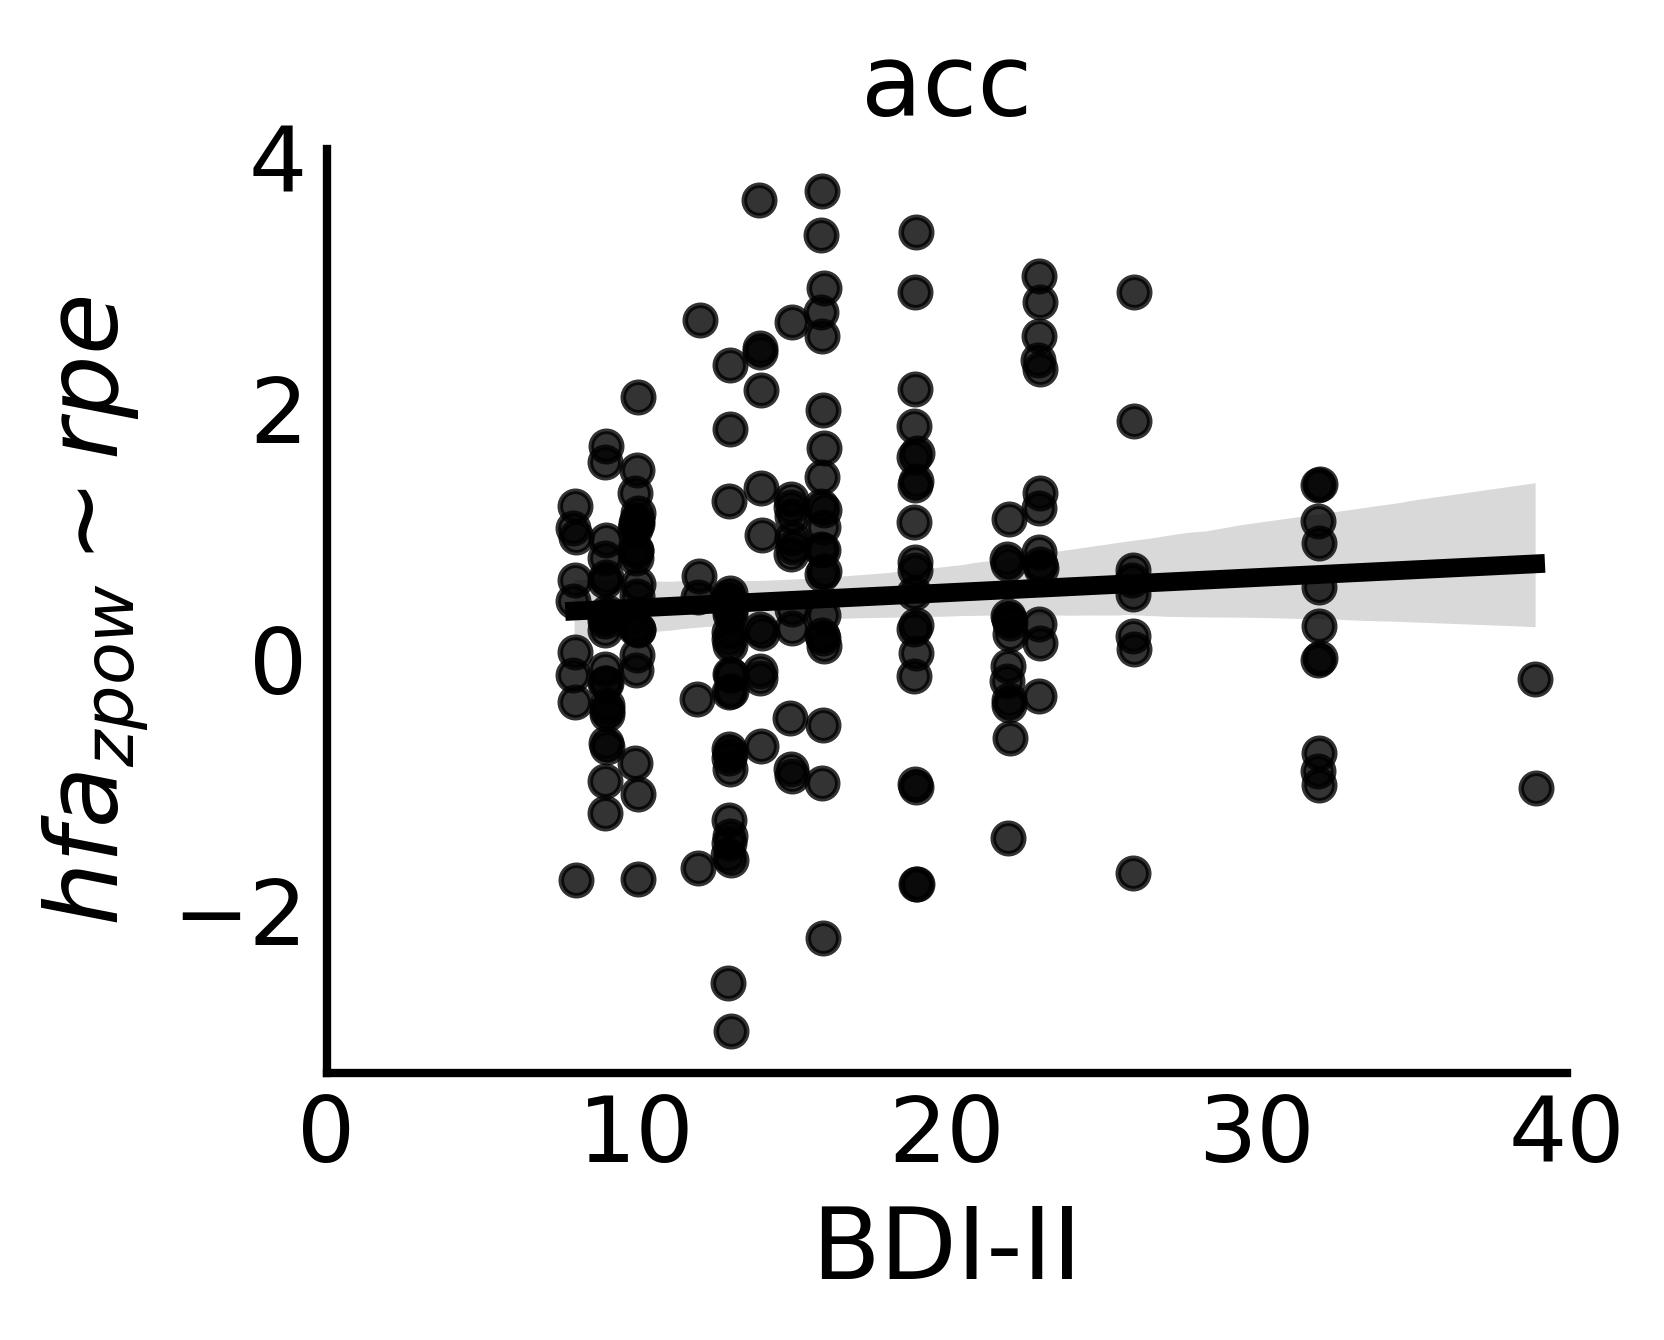

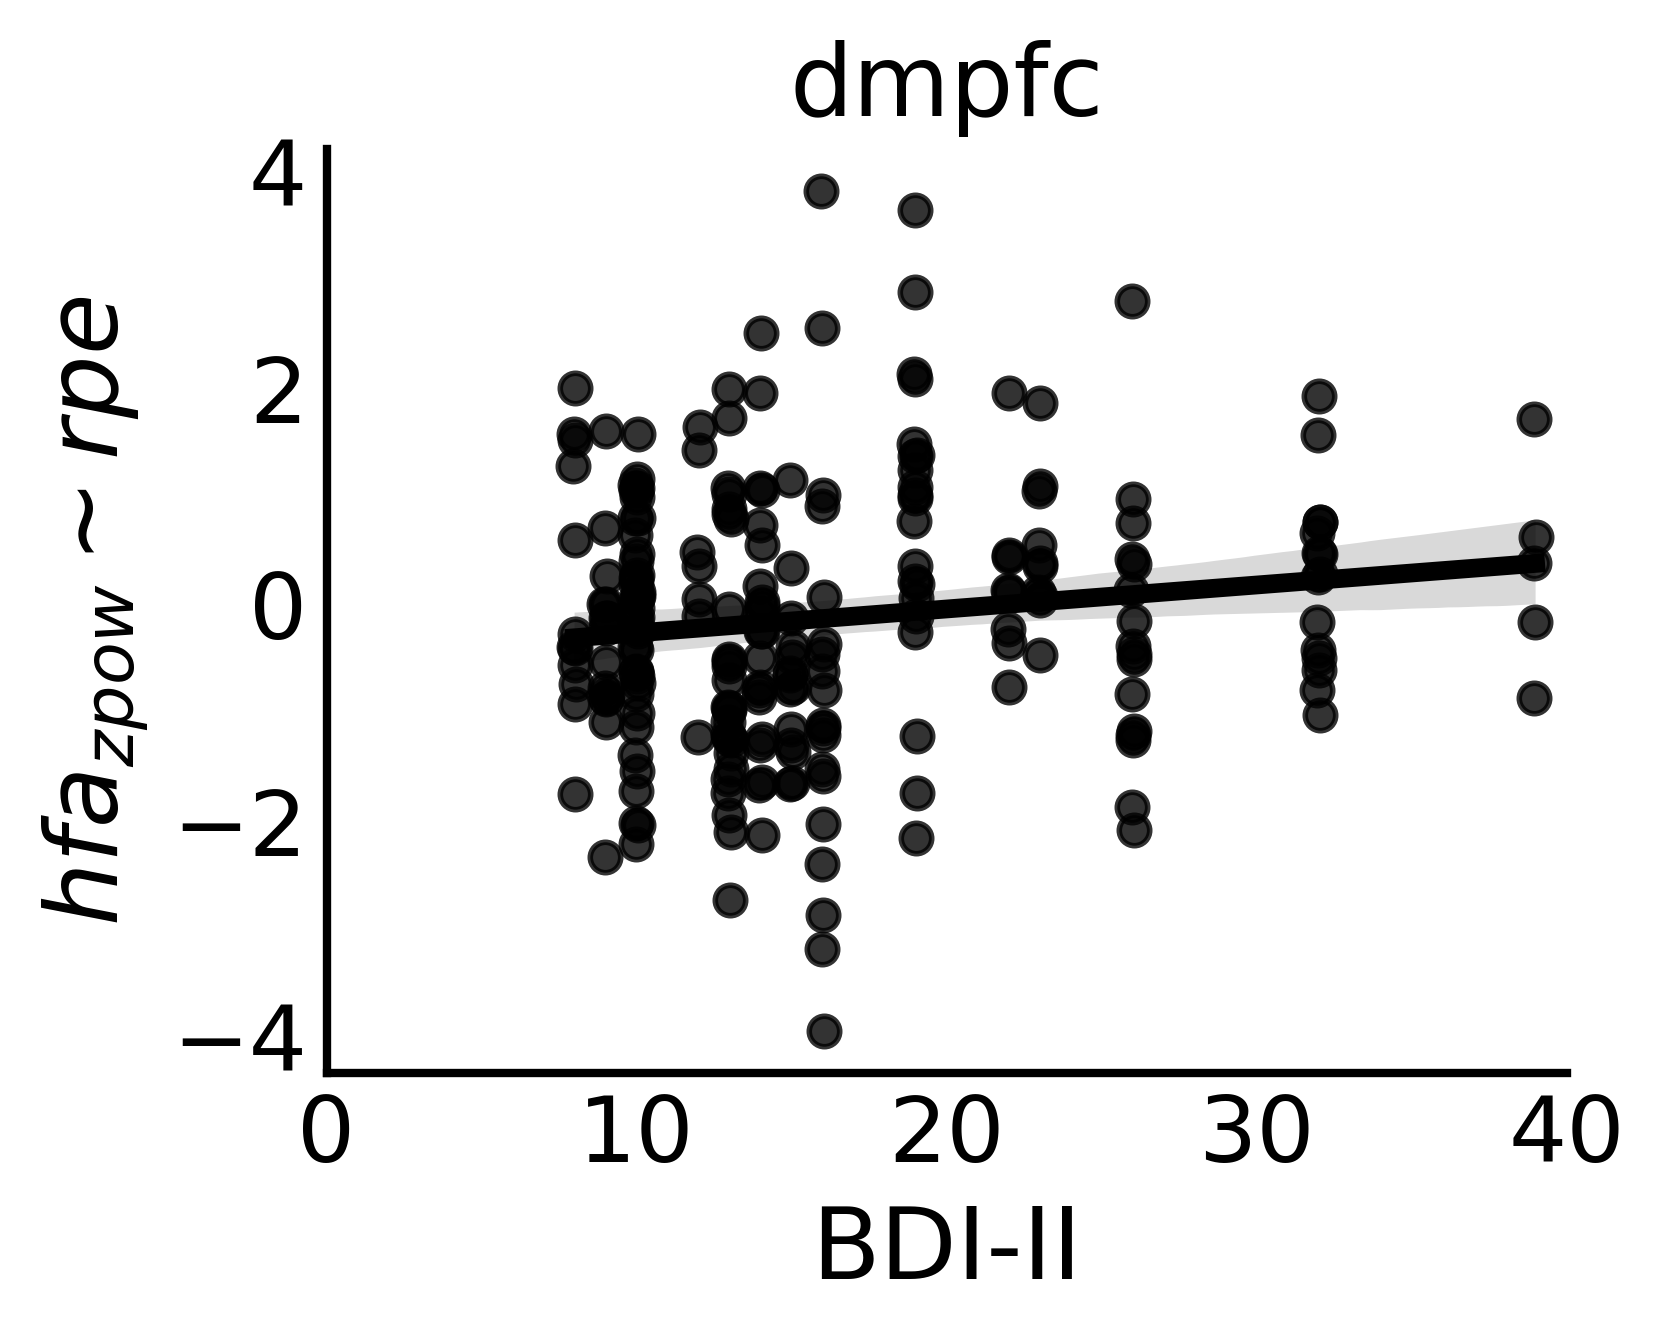

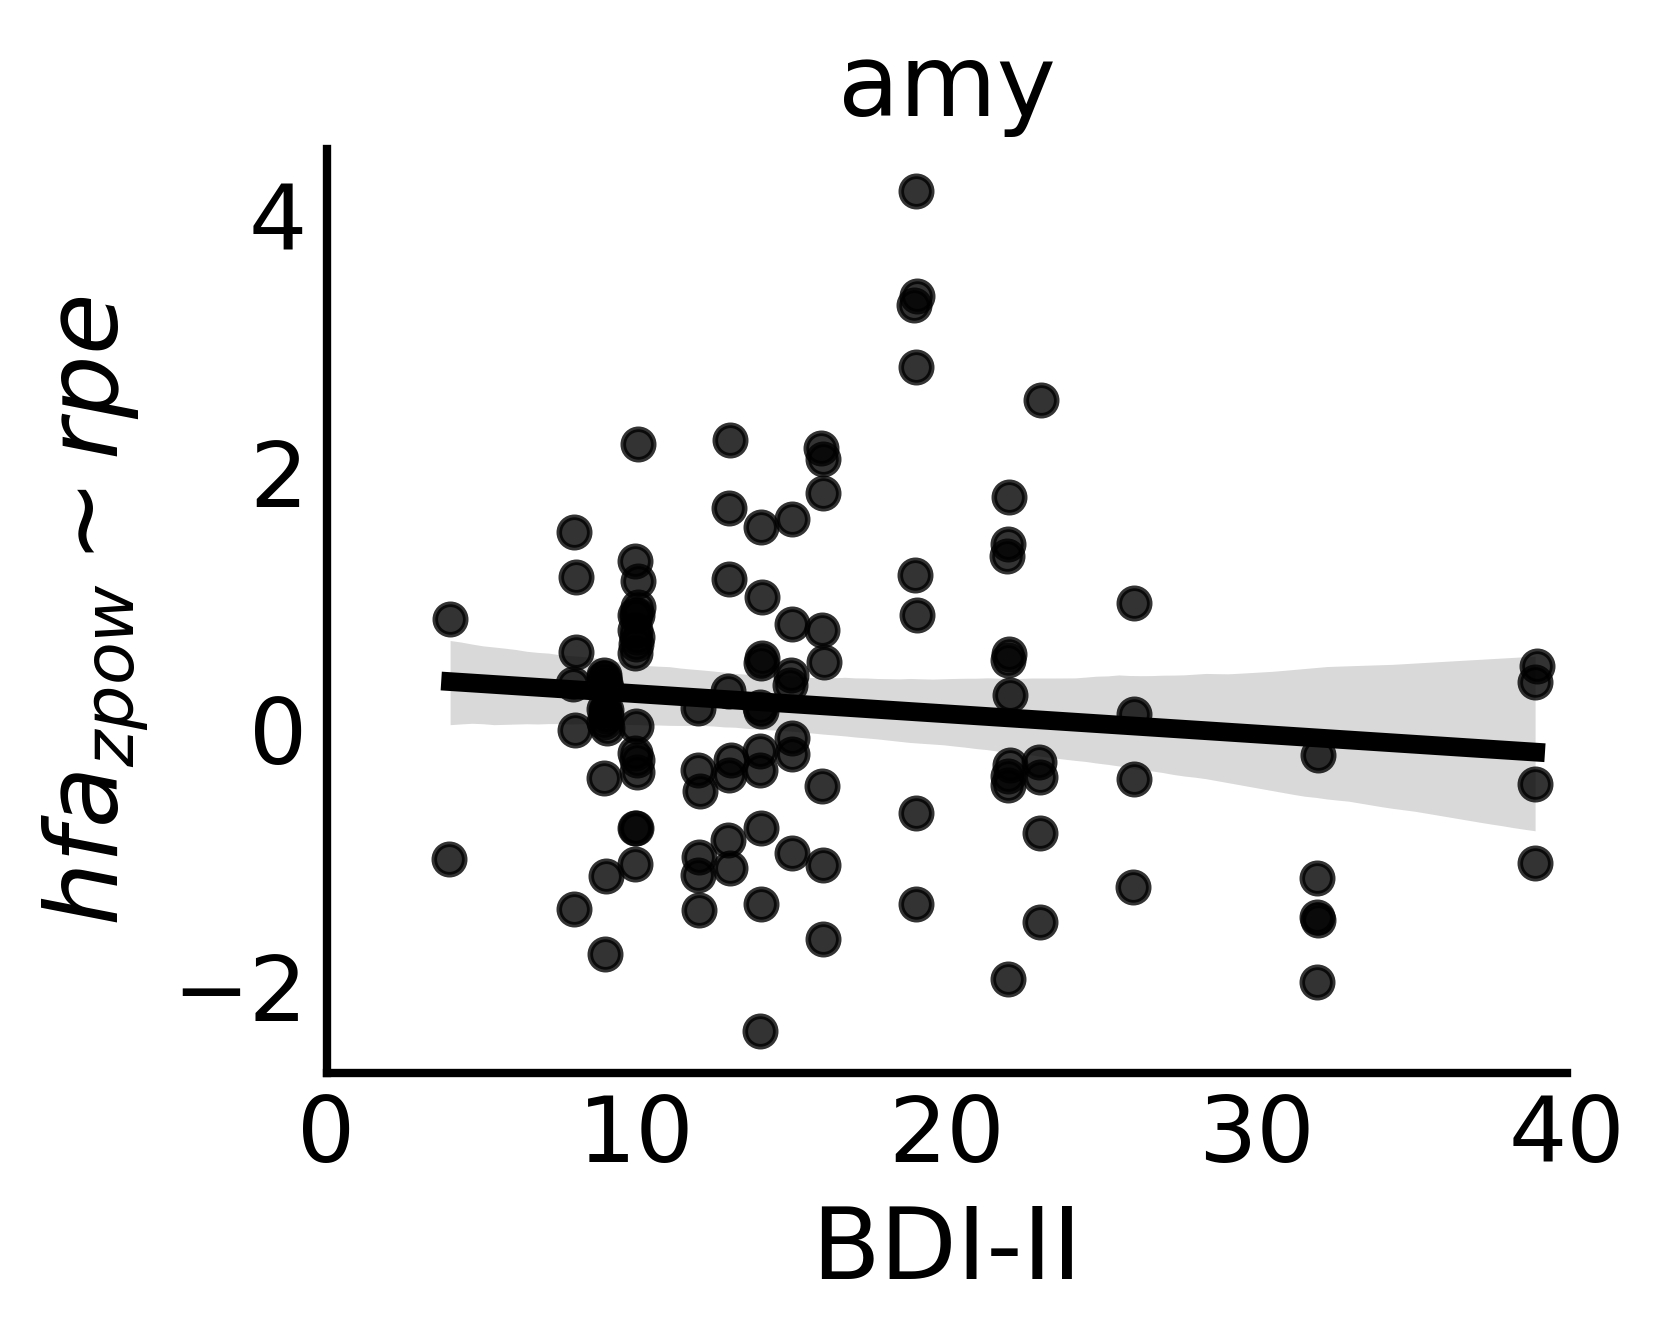

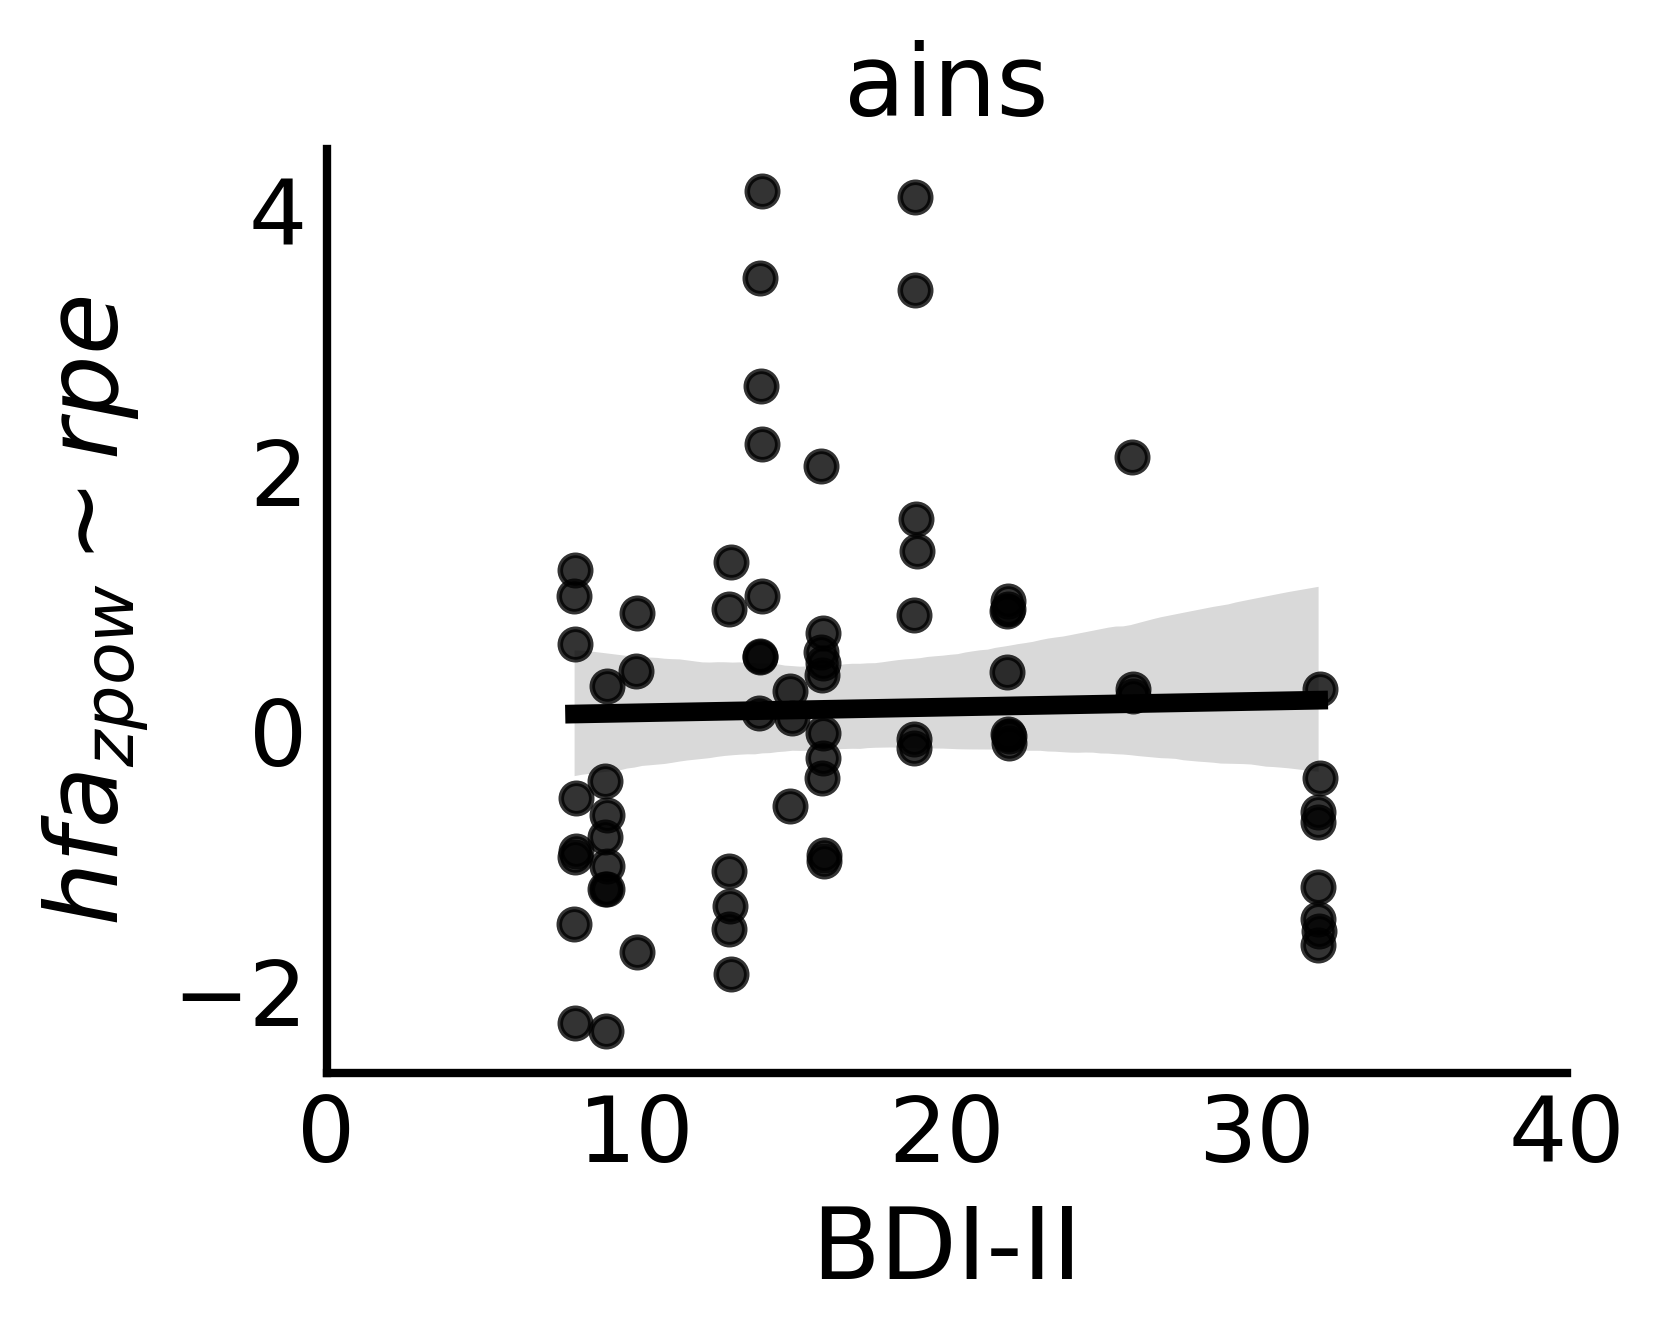

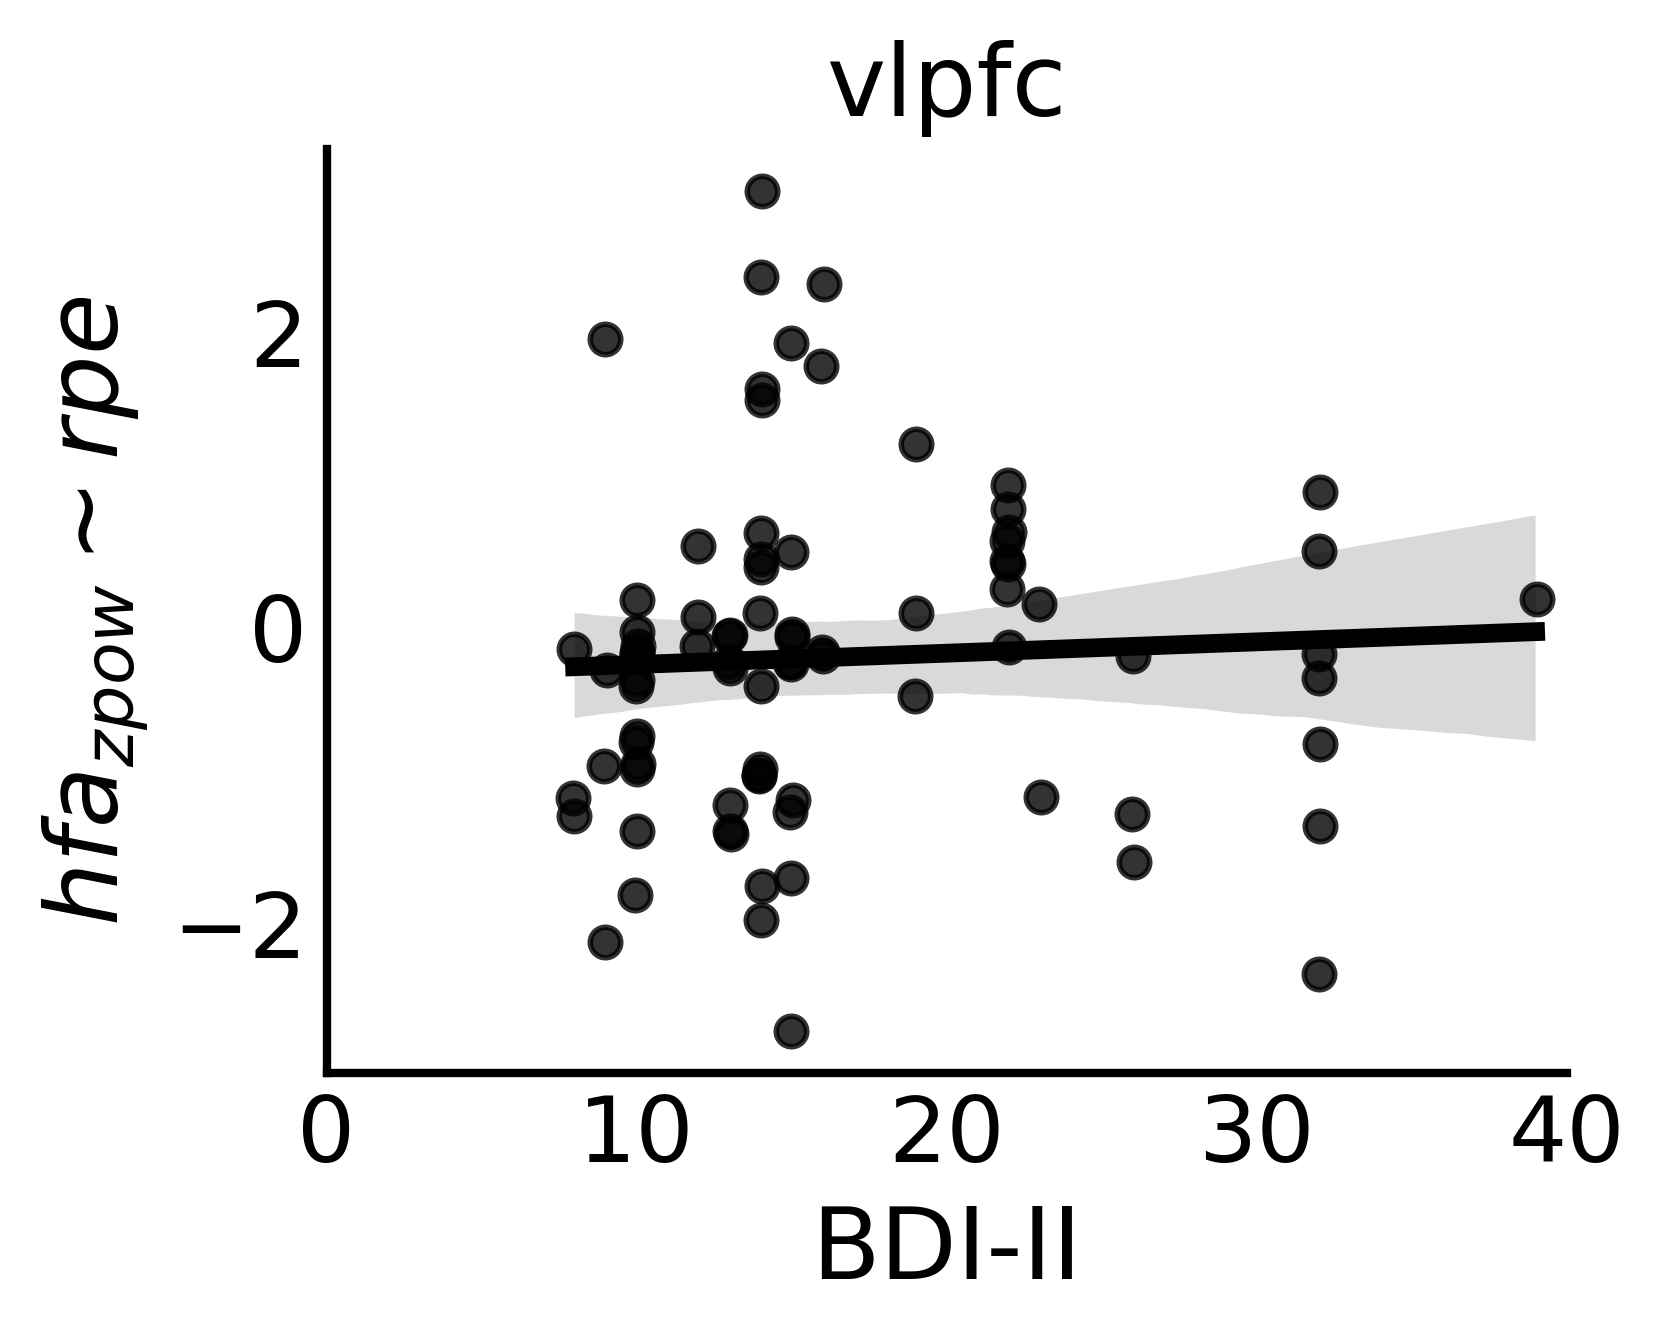

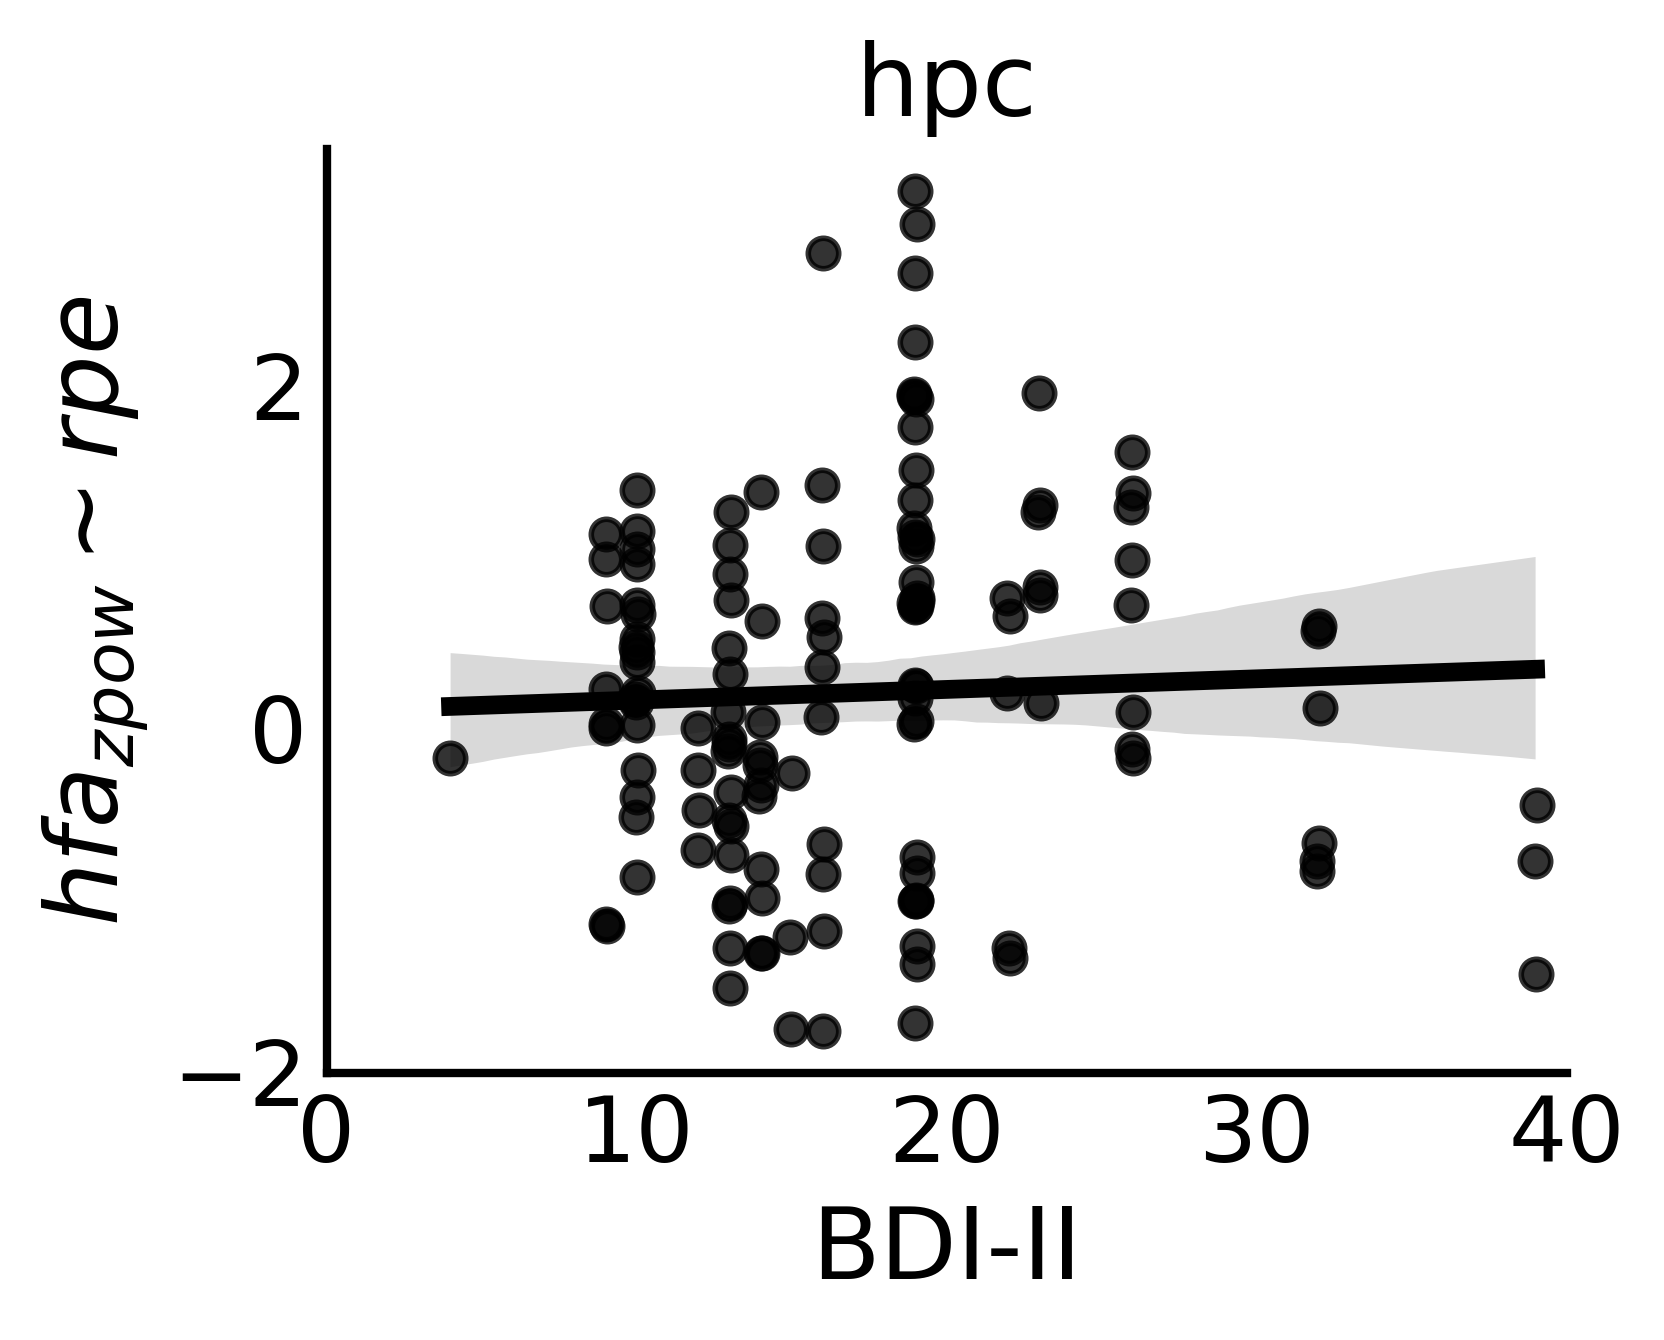

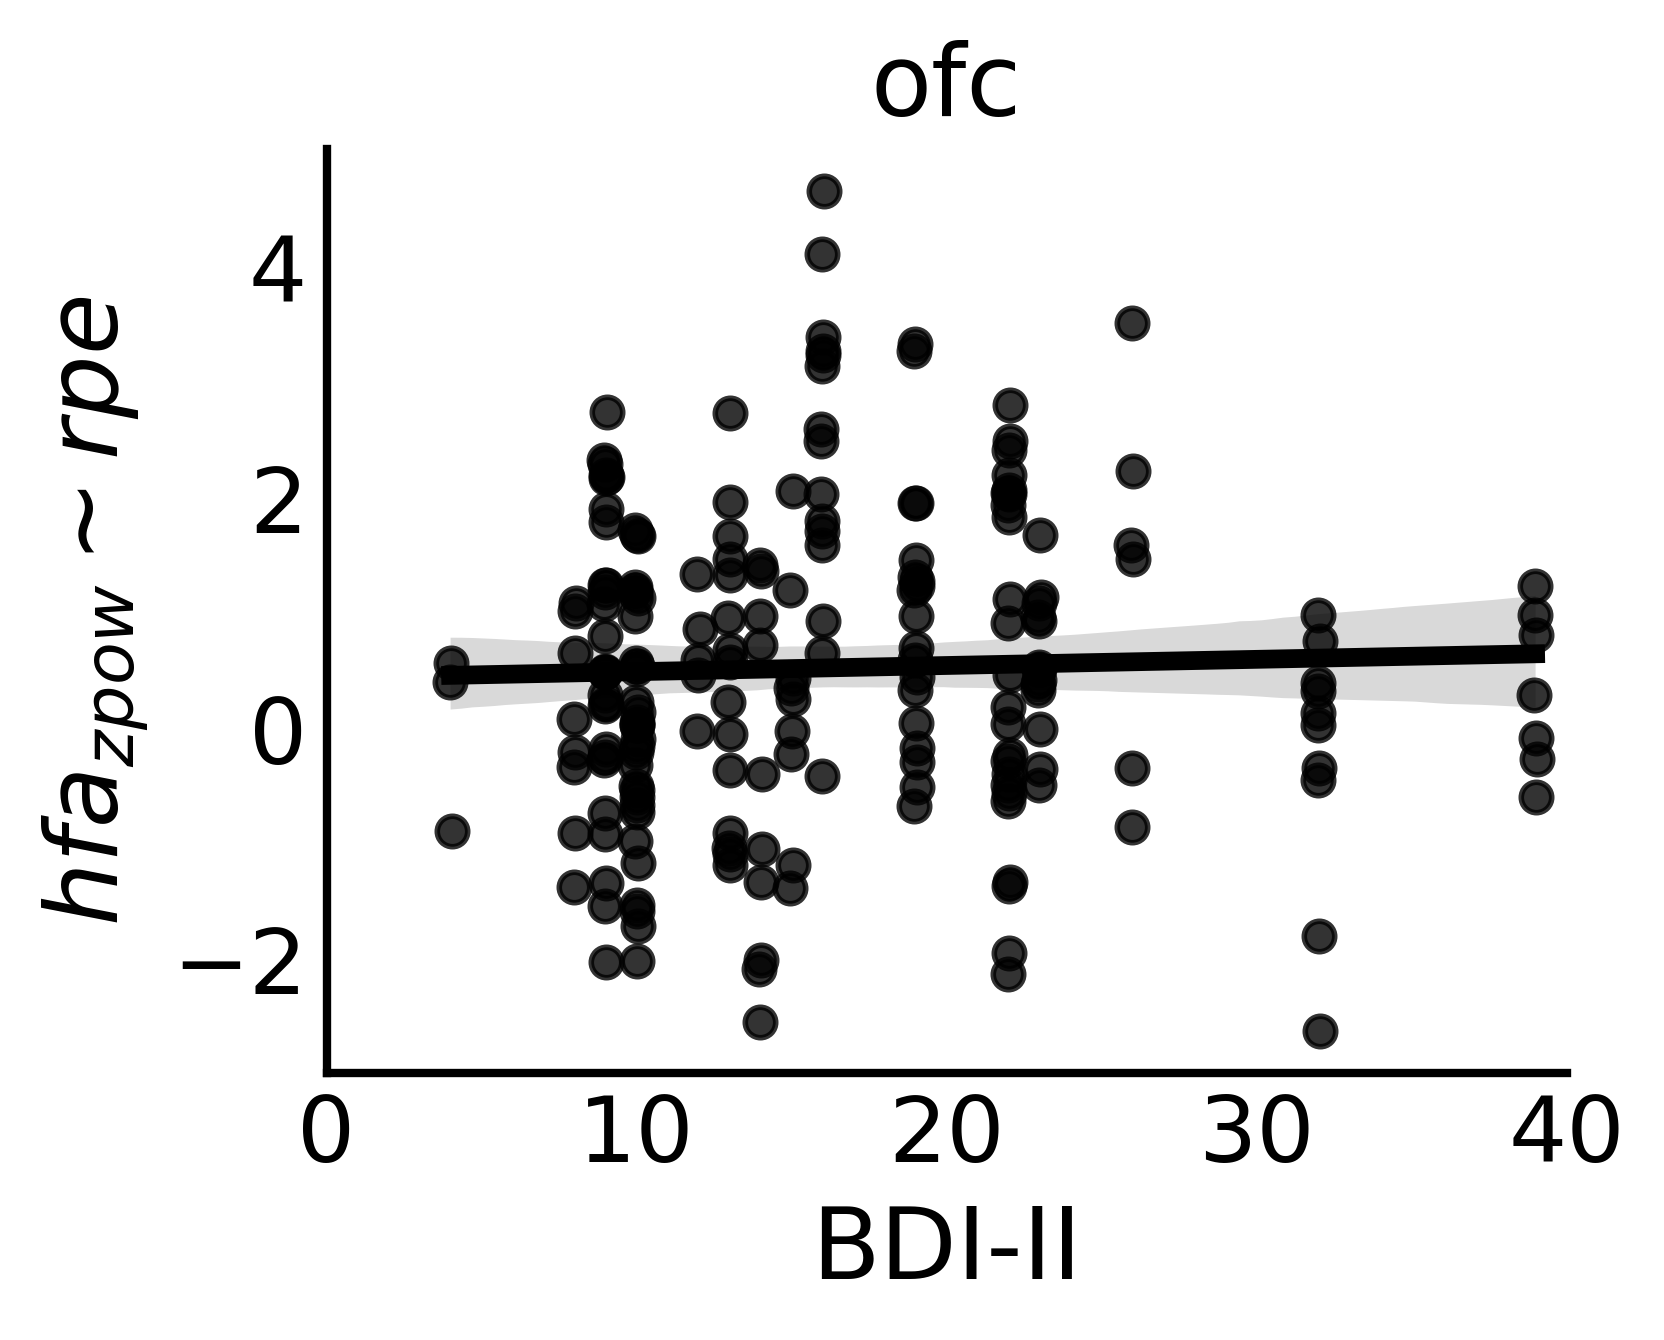

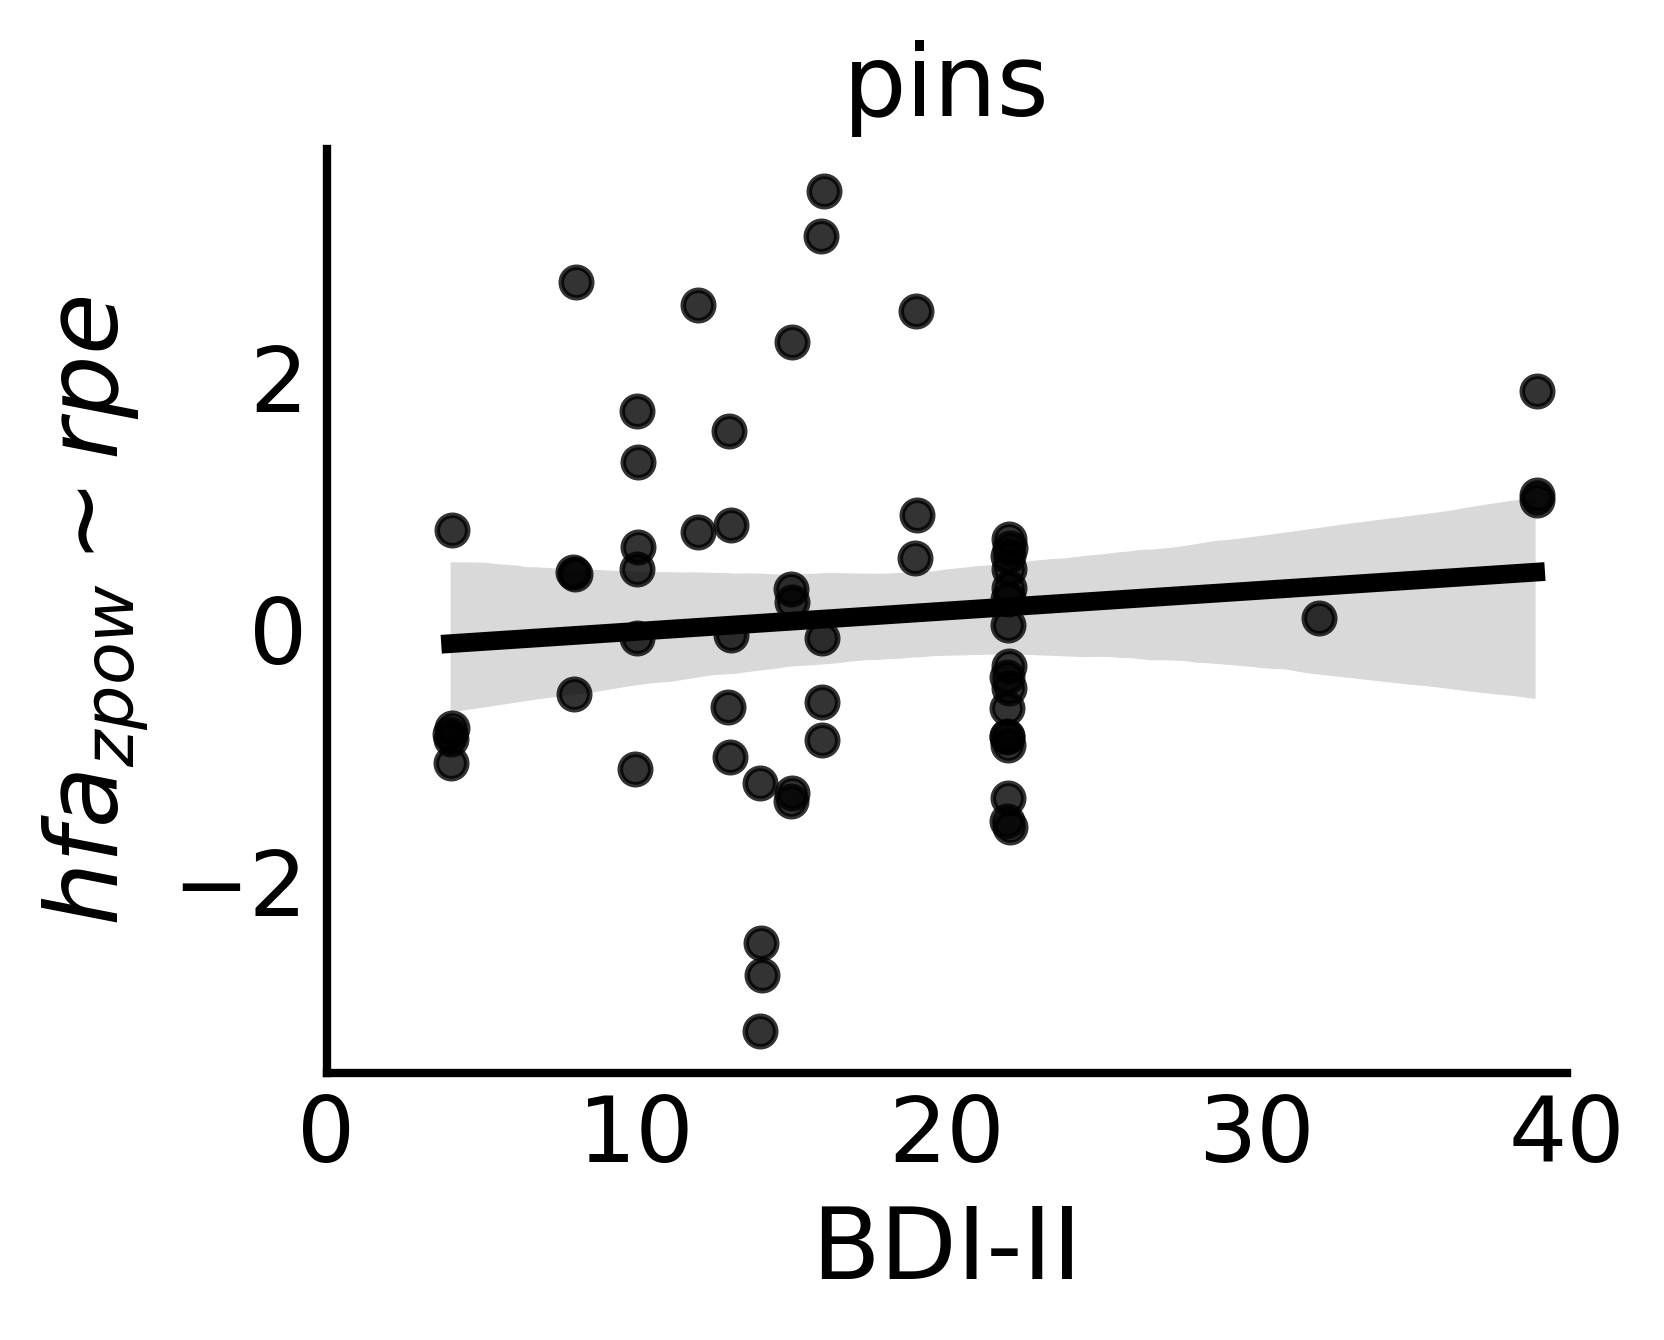

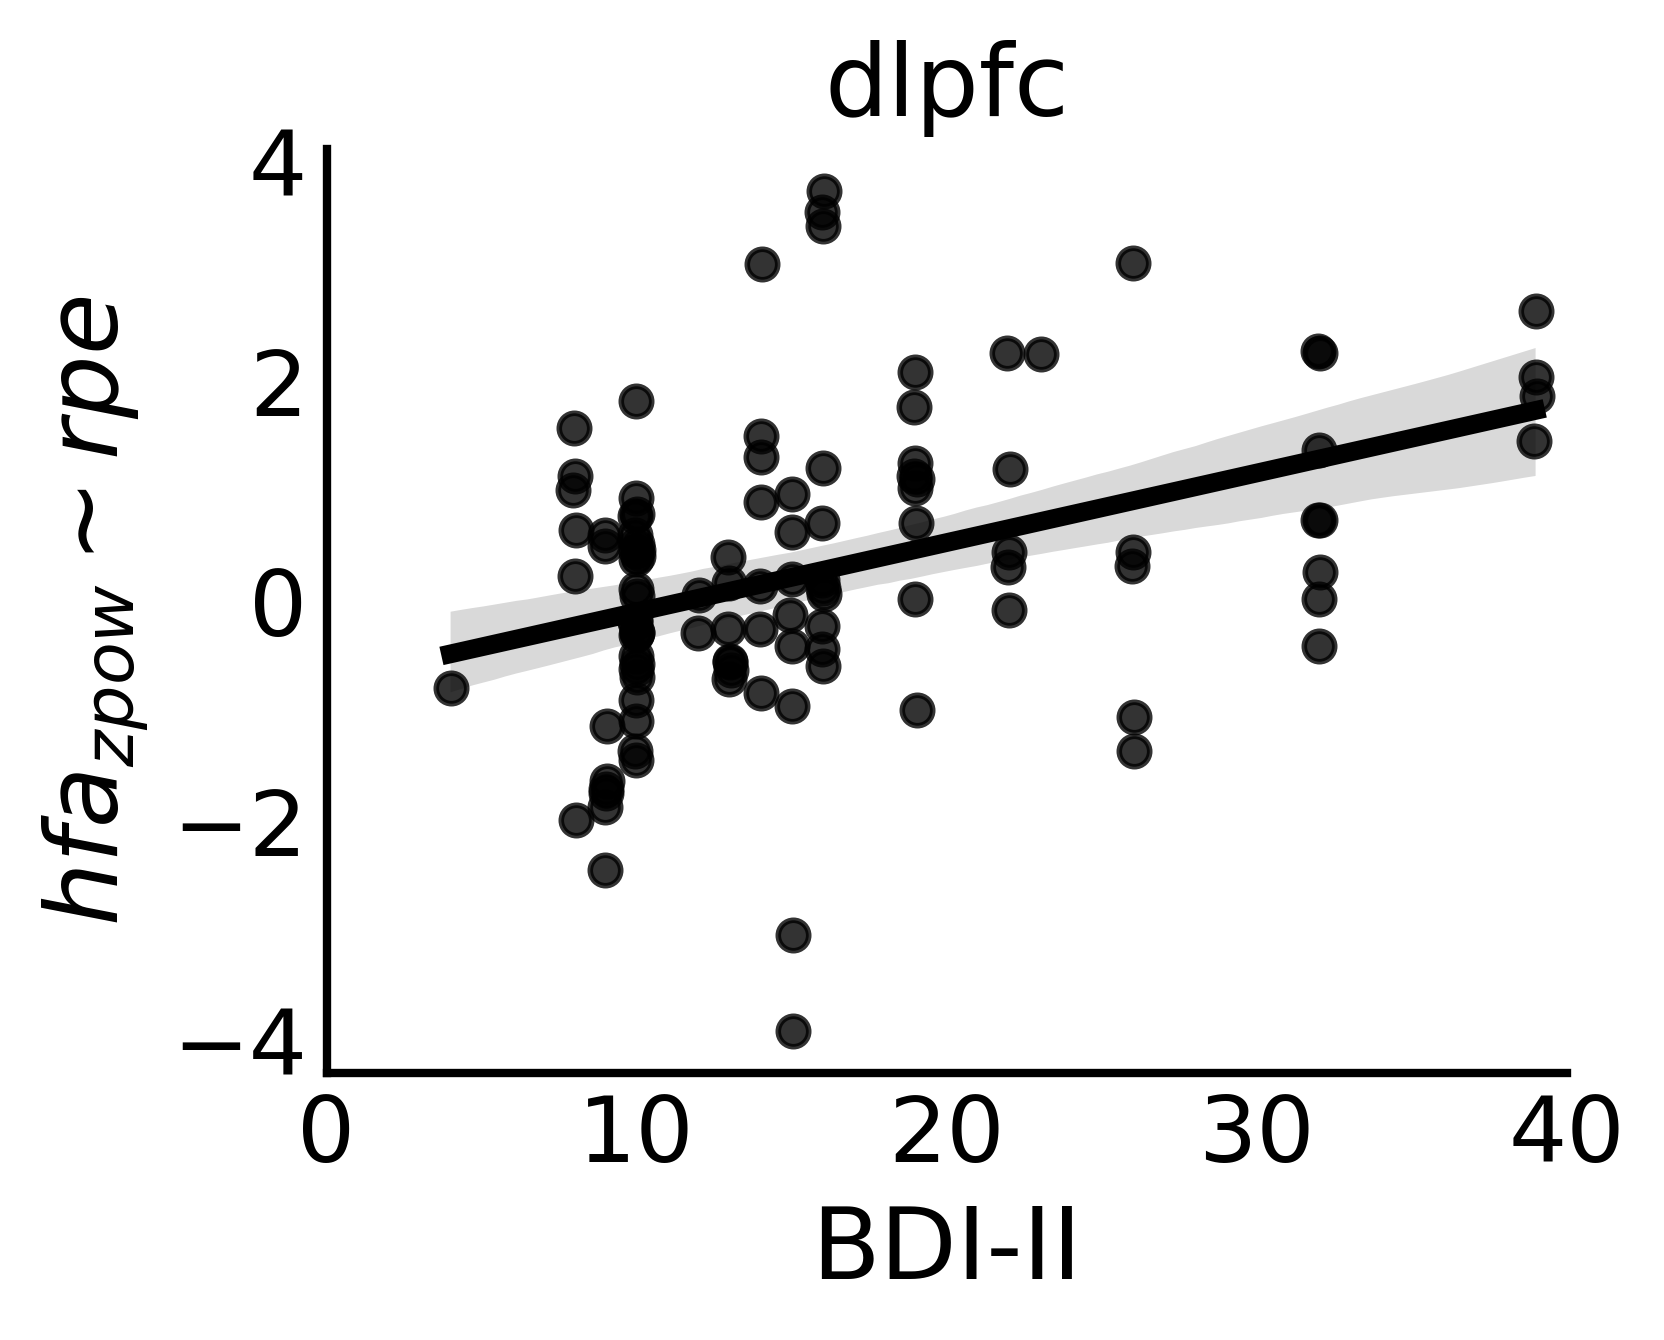

In [42]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_errormodels-bdi_rpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_rpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim rpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [43]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_rpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        21:28:46                                         
No. Iterations:                    20                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.5125      0.472     32.857     